# Mall Customer Segmentation

To group customers into distinct segments based on their behavior and characteristics, so businesses can understand and target them more effectively.
Through pre-processing data and clustering, we aim to transform raw data into meaningful insight. The project involves heavy experimentation, visualization, and model validation, emphasizing the intricacies of working with imbalanced, high-dimensional data.

In [4882]:
!pip install kneed

In [4883]:
!pip install category_encoders

In [4884]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,PowerTransformer,QuantileTransformer,OneHotEncoder
import kagglehub
import os
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans,MiniBatchKMeans,DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples,precision_score, recall_score, f1_score, confusion_matrix, classification_report,auc, precision_recall_curve,roc_curve,calinski_harabasz_score,davies_bouldin_score
from matplotlib.ticker import FixedLocator, FixedFormatter
from kneed import KneeLocator
import time
import psutil
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import NearestNeighbors

# Load Data

In [4885]:
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
csv_path = os.path.join(path, "Mall_Customers.csv")
mall_customers = pd.read_csv(csv_path)

In [4886]:
mall_customers.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

# Data Overview

In [4887]:
mall_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**All the features is numerical and only the ("Gender") feature is a categorical feature so we need to encode it later...**

In [4888]:
#Summary statistics
mall_customers.describe().T

count    mean        std   min    25%    50%     75%  \
CustomerID              200.0  100.50  57.879185   1.0  50.75  100.5  150.25   
Age                     200.0   38.85  13.969007  18.0  28.75   36.0   49.00   
Annual Income (k$)      200.0   60.56  26.264721  15.0  41.50   61.5   78.00   
Spending Score (1-100)  200.0   50.20  25.823522   1.0  34.75   50.0   73.00   

                          max  
CustomerID              200.0  
Age                      70.0  
Annual Income (k$)      137.0  
Spending Score (1-100)   99.0

In [4889]:
#check for missing values
print('Missing values:')
mall_customers.isnull().sum()

Missing values:


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

**The dataset does not contain any missing values**

# Features Distribution

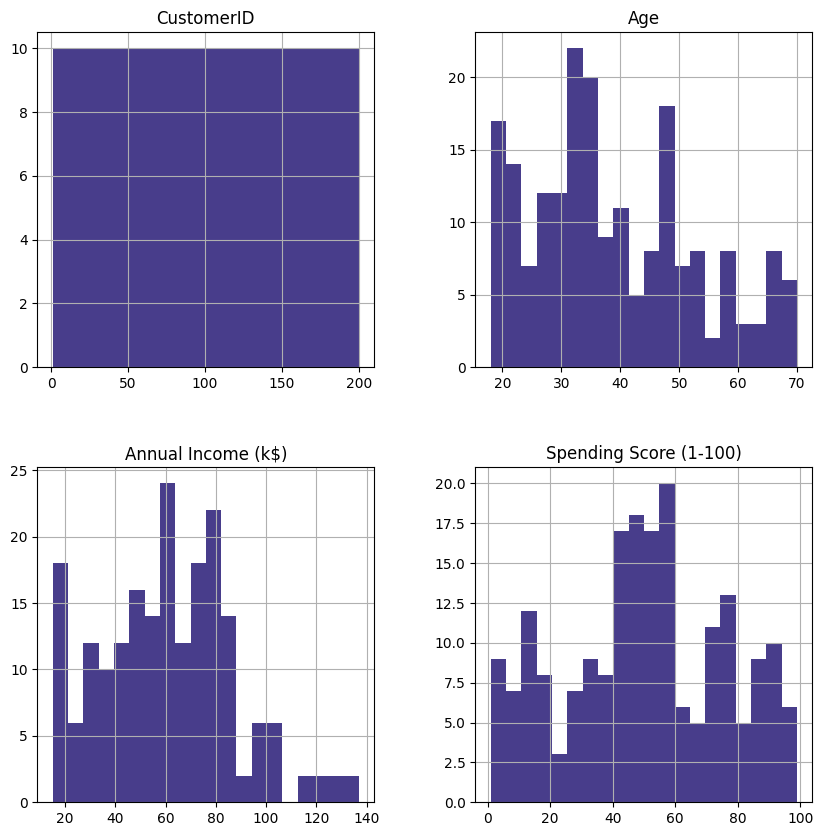

In [4890]:
mall_customers.hist(figsize=(10,10),bins=20,color='#483D8B')
plt.show()

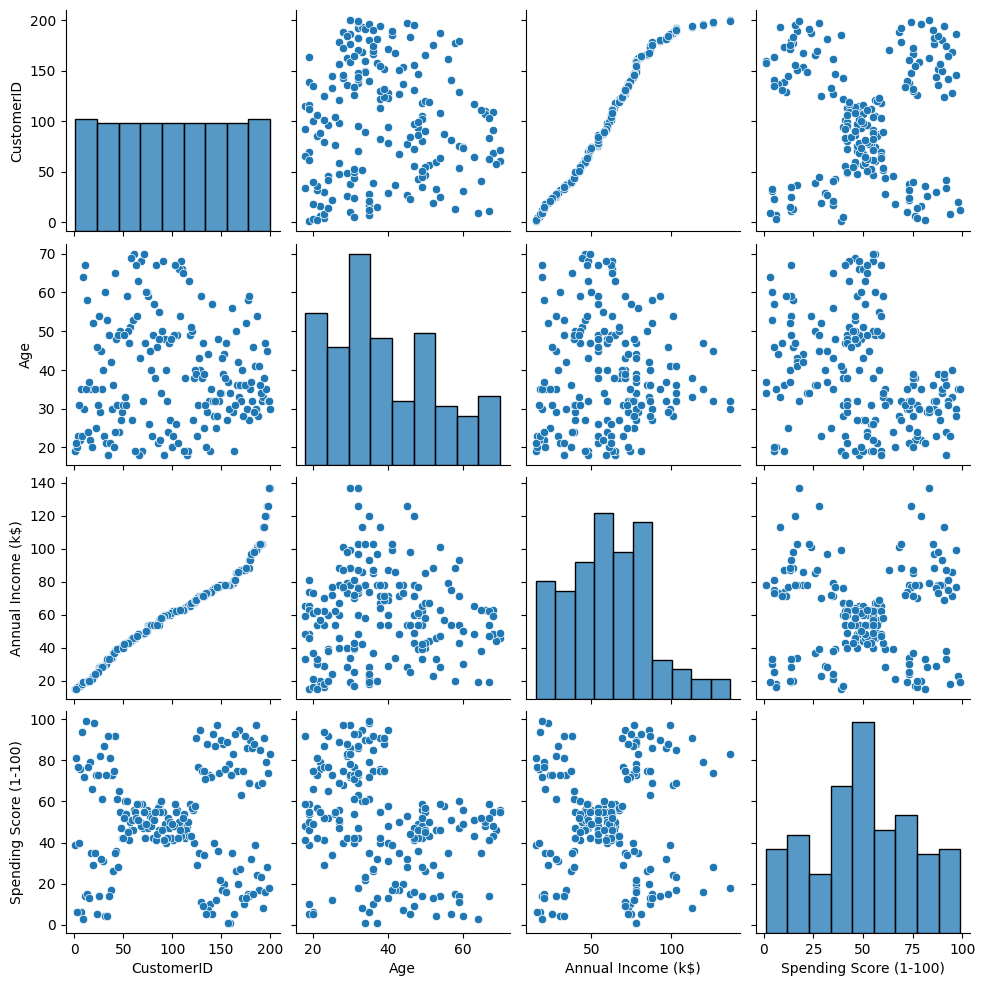

In [4891]:
sample = mall_customers.sample(200)
sns.pairplot(sample)
#It plots the correlation between every feature and itself

<Axes: xlabel='Gender', ylabel='Count'>

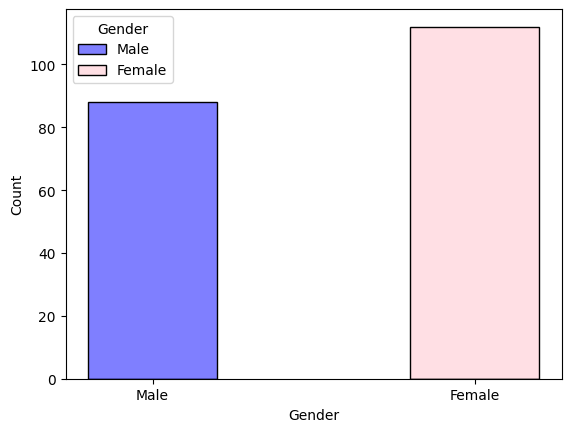

In [4892]:
sns.histplot(x='Gender', data=mall_customers, hue='Gender',
             palette=['blue', 'pink'] , shrink = 0.4)
# shrink mean the value size on the x axis

**Here we see that the majority is Female**

Text(0.5, 1.0, 'Age Distribution')

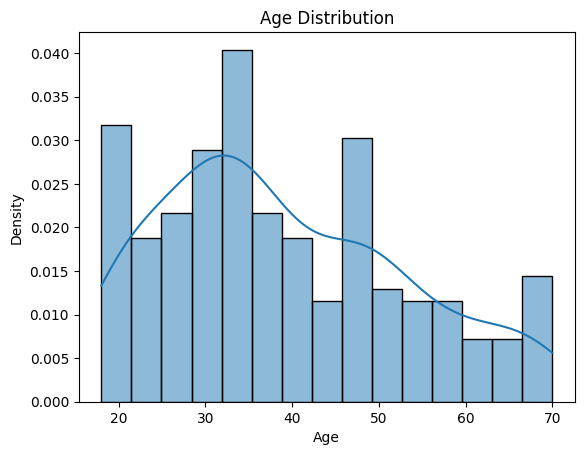

In [4893]:
sns.histplot(mall_customers['Age'] , stat='density' , bins =15 , kde=True)
plt.title("Age Distribution")

**The majority here in the Age in range between 30-35 and it's almost uniform distribution**

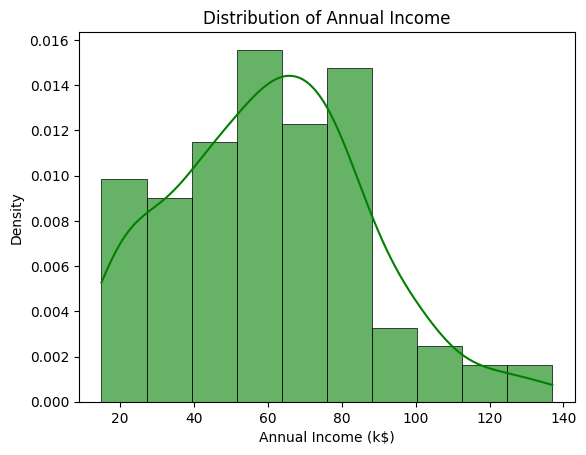

In [4894]:
sns.histplot(data=mall_customers,x="Annual Income (k$)",stat="density",kde=True,color="green",alpha=0.6,linewidth=0.5,bins=10)

plt.xlabel('Annual Income (k$)')
plt.ylabel('Density')
plt.title('Distribution of Annual Income')
plt.show()

Text(0, 0.5, 'Density')

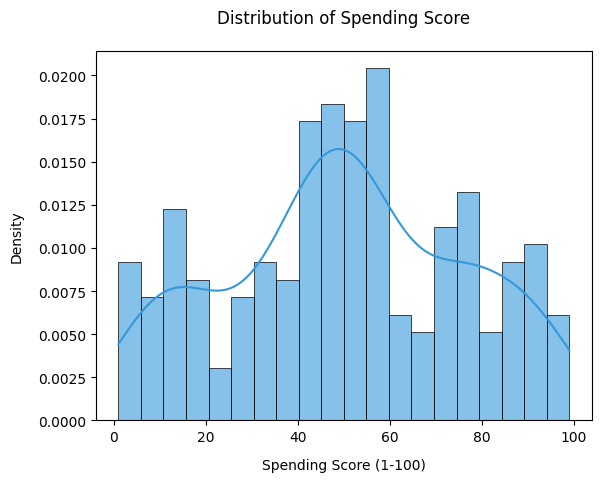

In [4895]:
sns.histplot(data=mall_customers,x="Spending Score (1-100)",stat="density",kde=True,color="#3498db",alpha=0.6,linewidth=0.5,bins=20)
plt.title("Distribution of Spending Score", pad=20)
plt.xlabel("Spending Score (1-100)", labelpad=10)
plt.ylabel("Density", labelpad=10)

The peak from 40-60

Number of components to retain 90% variance: 4


<ipython-input-4896-f66590d38940>:7: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



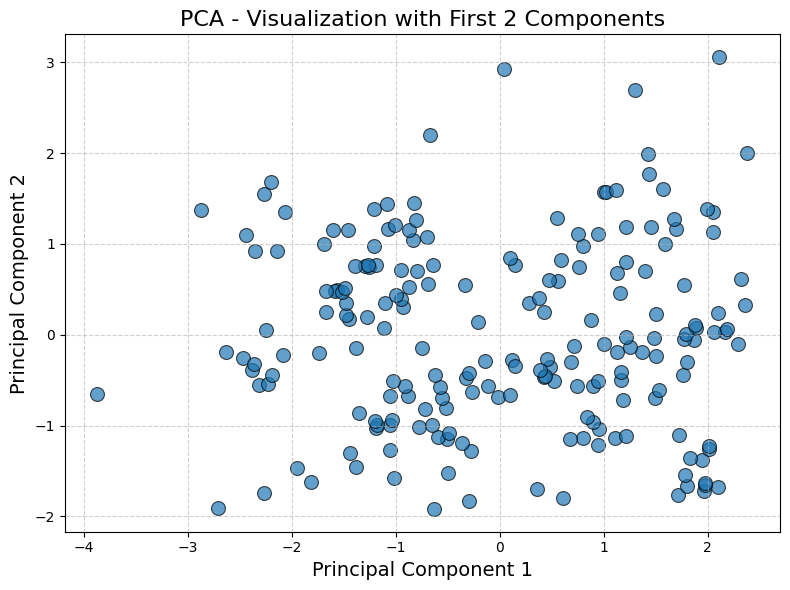

In [4896]:



pca = PCA(n_components=0.93)
X_pca = pca.fit_transform(X_scaled)
print("Number of components to retain 90% variance:" ,pca.n_components_)
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=['#483D8B','#E7F255'], s=100, alpha=0.7, edgecolor='k', marker='o')
plt.title('PCA - Visualization with First 2 Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# **Preprocessing**

# Feature Engineering

In [4897]:
mall_customers['Avg_Spending_By_Gender'] = mall_customers.groupby('Gender')['Spending Score (1-100)'].transform('mean')

In [4898]:
'''mall_customers['Radial_Angle'] = np.arctan2(
    mall_customers['Spending Score (1-100)'],
    mall_customers['Annual Income (k$)']
)'''

"mall_customers['Radial_Angle'] = np.arctan2(\n    mall_customers['Spending Score (1-100)'], \n    mall_customers['Annual Income (k$)']\n)"

In [4899]:
#mall_customers['Income_per_spending'] = mall_customers['Annual Income (k$)'] / mall_customers['Spending Score (1-100)']

The 'Income_per_spending' feature calculates the ratio of annual income to spending score, measuring how much income a customer earns relative to their spending habits. This helps identify distinct financial behavior patterns, such as high-income conservative spenders (high ratio) versus low-income big spenders (low ratio), for more nuanced customer segmentation

In [4900]:
#chat gpt
#mall_customers['Income_per_Age'] = mall_customers['Annual Income (k$)'] / mall_customers['Age']


# mall_customers['SpendingCategory'] = pd.cut(mall_customers['Spending Score (1-100)'],bins=[0, 33, 66, 100],labels=[0,1,2])

# def bin_income(df):
#     bins = [0, 40, 70, 150]
#     labels = [0, 1, 2]
#     df['Income_Bin'] = pd.cut(df['Annual Income (k$)'], bins=bins, labels=labels)
#     return df
# bin_income(mall_customers)

In [4901]:
'''# Bin Spending Score and drop the original column
mall_customers['SpendingCategory'] = pd.cut(
    mall_customers['Spending Score (1-100)'],
    bins=[0, 33, 66, 100],
    labels=[0, 1, 2]
)
mall_customers.drop('Spending Score (1-100)', axis=1, inplace=True)

# Bin Income and drop the original column
mall_customers['Income_Bin'] = pd.cut(
    mall_customers['Annual Income (k$)'],
    bins=[0, 40, 70, 150],
    labels=[0, 1, 2]
)
mall_customers.drop('Annual Income (k$)', axis=1, inplace=True)'''


"# Bin Spending Score and drop the original column\nmall_customers['SpendingCategory'] = pd.cut(\n    mall_customers['Spending Score (1-100)'],\n    bins=[0, 33, 66, 100],\n    labels=[0, 1, 2]\n)\nmall_customers.drop('Spending Score (1-100)', axis=1, inplace=True)\n\n# Bin Income and drop the original column\nmall_customers['Income_Bin'] = pd.cut(\n    mall_customers['Annual Income (k$)'],\n    bins=[0, 40, 70, 150],\n    labels=[0, 1, 2]\n)\nmall_customers.drop('Annual Income (k$)', axis=1, inplace=True)"

In [4902]:
#mall_customers['Age_Spending_Interaction'] = mall_customers['Age'] * mall_customers['Spending Score (1-100)']

The Age_Spending_Interaction feature multiplies age by spending score to capture how spending behavior scales with age, helping identify unique customer segments like 'high-spending youth' or 'low-spending seniors' that might be missed when analyzing age or spending alone

In [4903]:
'''from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mall_customers['Age_Normalized'] = scaler.fit_transform(mall_customers[['Age']])'''

"from sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\nmall_customers['Age_Normalized'] = scaler.fit_transform(mall_customers[['Age']])"

# Encoding


**Encoding our categorical feature ("Gender") using the binary encoder**

In [4904]:
'''mall_customers['Gender'] = mall_customers['Gender'].map({'Female': 0, 'Male': 1})'''

"mall_customers['Gender'] = mall_customers['Gender'].map({'Female': 0, 'Male': 1})"

In [4905]:
encoder= OneHotEncoder(sparse_output=False, drop='first')
gender_encoded=encoder.fit_transform(mall_customers[['Gender']])
gender_encoded_df=pd.DataFrame(gender_encoded,columns=encoder.get_feature_names_out(['Gender']),index=mall_customers.index)
mall_customers = pd.concat([mall_customers.drop('Gender', axis=1), gender_encoded_df], axis=1)

In [4906]:
mall_customers

CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  \
0             1   19                  15                      39   
1             2   21                  15                      81   
2             3   20                  16                       6   
3             4   23                  16                      77   
4             5   31                  17                      40   
..          ...  ...                 ...                     ...   
195         196   35                 120                      79   
196         197   45                 126                      28   
197         198   32                 126                      74   
198         199   32                 137                      18   
199         200   30                 137                      83   

     Avg_Spending_By_Gender  Gender_Male  
0                 48.511364          1.0  
1                 48.511364          1.0  
2                 51.526786          0.0  
3                 51.526786          0.0  
4                 51.526786          0.0  
..                      ...          ...  
195               51.526786          0.0  
196               51.526786          0.0  
197               48.511364          1.0  
198               48.511364          1.0  
199               48.511364          1.0  

[200 rows x 6 columns]

**Gender_1 is male **

**We will drop the ("CustomerID") feature because it cannot affect anything at work.**

In [4907]:
mall_customers = mall_customers.drop(['CustomerID'], axis=1)

In [4908]:
mall_customers

Age  Annual Income (k$)  Spending Score (1-100)  Avg_Spending_By_Gender  \
0     19                  15                      39               48.511364   
1     21                  15                      81               48.511364   
2     20                  16                       6               51.526786   
3     23                  16                      77               51.526786   
4     31                  17                      40               51.526786   
..   ...                 ...                     ...                     ...   
195   35                 120                      79               51.526786   
196   45                 126                      28               51.526786   
197   32                 126                      74               48.511364   
198   32                 137                      18               48.511364   
199   30                 137                      83               48.511364   

     Gender_Male  
0            1.0  
1            1.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
195          0.0  
196          0.0  
197          1.0  
198          1.0  
199          1.0  

[200 rows x 5 columns]

In [4909]:
skewed_features = mall_customers.skew().sort_values(ascending=False)
skewed_features

Age                       0.485569
Annual Income (k$)        0.321843
Gender_Male               0.243578
Spending Score (1-100)   -0.047220
Avg_Spending_By_Gender   -0.243578
dtype: float64

**All features is approximately symmetric.So no need to fix it**

In [4910]:
Q75=mall_customers.quantile(0.75)
Q25=mall_customers.quantile(0.25)
IQR=Q75-Q25
min_point= Q25- IQR*1.5
max_point= Q75+ IQR*1.5
Outliers=((mall_customers<min_point)|(mall_customers>max_point))
print(Outliers.sum())

Age                       0
Annual Income (k$)        2
Spending Score (1-100)    0
Avg_Spending_By_Gender    0
Gender_Male               0
dtype: int64


There is no outliers...only 2 datapoints in the ("Annual Income (k$)") so no need to fix it..

In [4911]:
threshold = 0.9
FeaturesCorr=mall_customers.corr().abs()
for feature in FeaturesCorr.columns:

    high_corr = FeaturesCorr[feature][(FeaturesCorr[feature] > threshold) & (FeaturesCorr[feature] < 1)].index.tolist()

high_corr

[]

NO features in the dataset have a correlation higher than 0.5 with each other.

Lets see the heatmap to show everything...

Text(0.5, 1.0, 'Correlation Matrix')

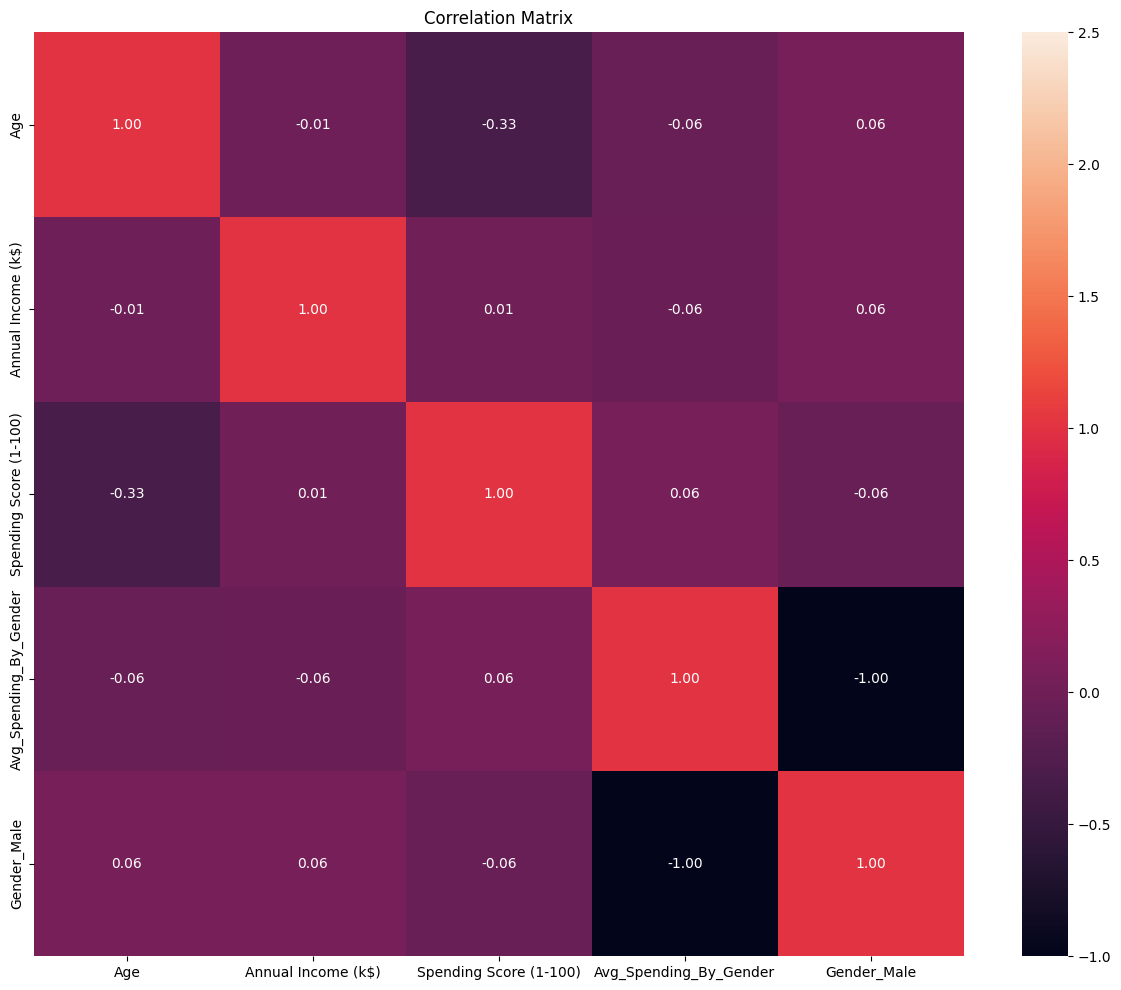

In [4912]:
plt.figure(figsize=(15,12))
sns.heatmap(mall_customers.corr(),annot=True,fmt=".2f", vmin=-1, vmax=2.5)
plt.title('Correlation Matrix')

Interpretation
The data can be separated into two clear groups based on their positions in this PCA space.

This indicates that the underlying classes in the original dataset are well-separated when projected into two dimensions.

PCA has successfully preserved the class-discriminative structure in just two dimensions.

# Scaling

In [4913]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(mall_customers)

# PCA

In [4914]:
pca = PCA().fit(X_scaled)

In [4915]:
eigenvalues=pca.explained_variance_
eigenvalues

array([2.03623616e+00, 1.31604164e+00, 9.96711514e-01, 6.76136318e-01,
       2.77555756e-16])

pca.explained_variance_ returns the **eigenvalues** corresponding to each principal component. These values represent the **amount of variance** captured by each component in the transformed feature space.

This means:
- The **first principal component** captures 2.38 units of variance from the original data.
- The **second principal component** captures 2.07 units.
- The **third principal component** captures 1.63 units, and so on.

Larger eigenvalues indicate that the component explains more variability in the data. PCA arranges components in decreasing order of these values, so the first components are the most informative. These eigenvalues are also used to compute the explained variance ratio, which helps in selecting the number of components to retain.




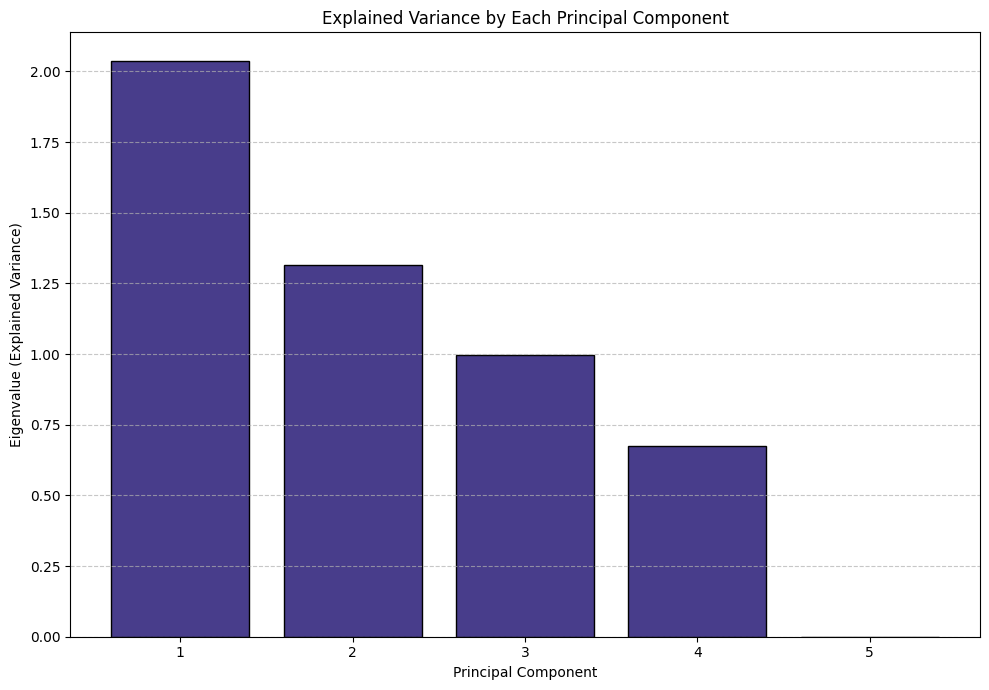

In [4916]:
components = np.arange(1, len(eigenvalues) + 1)

plt.figure(figsize=(10, 7))
plt.bar(components, eigenvalues, color='#483D8B', edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Explained Variance by Each Principal Component')
plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [4917]:
cumulativeVariance=np.cumsum(pca.explained_variance_ratio_)#This line calculates the cumulative sum of the variance explained by each principal component in PCA
cumulativeVariance

array([0.405211  , 0.66710328, 0.86544887, 1.        , 1.        ])

The goal is to calculate the total variance explained by the first n principal components, helping decide how many components are needed to capture a desired percentage of the total variance.

In [4918]:
n_components=np.argmax(cumulativeVariance>=0.90)+1 #Determines the number of principal components needed to retain at least 93% of the cumulative variance in PCA
print('The number of principal component is:' ,n_components)

The number of principal component is: 4


In [4919]:
plt.figure(figsize=(10,6))
fig = go.Figure()
#cumulative variance plot
fig.add_trace(go.Scatter(x=list(range(1, len(cumulativeVariance) + 1)),
                         y=cumulativeVariance,
                         mode='markers+lines',
                         name='Cumulative Variance',
                         marker=dict(color='#483D8B')
                        ))

# Add the 95% threshold line
fig.add_trace(go.Scatter(x=[1, len(cumulativeVariance)],
                         y=[0.93, 0.93],
                         mode='lines',
                         name='93% Threshold',
                         line=dict(dash='dash'),
                         marker=dict(color='#E7F255')
                        ))


fig.update_layout(
    title="Cumulative Variance vs Number of Principal Components",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Variance Percentage",
    template="plotly_dark",
    showlegend=True
)

fig.show()

<Figure size 1000x600 with 0 Axes>

In [4920]:
print(X_scaled.shape)

(200, 5)


In [4921]:
pca2=PCA(n_components=n_components)
X_train_pca=pca2.fit_transform(X_scaled)

In [4922]:
print(X_train_pca.shape)

(200, 4)


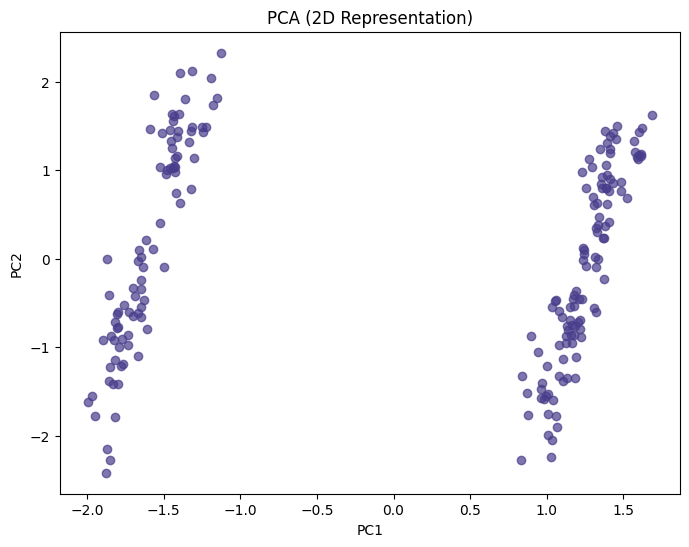

In [4923]:
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], alpha=0.7,color='#483D8B')# the components are chosen randomly
plt.title('PCA (2D Representation)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# TSNE

In [4924]:
tsne=TSNE(n_components=1,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_train_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.013268
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.644554
[t-SNE] KL divergence after 500 iterations: 0.401209


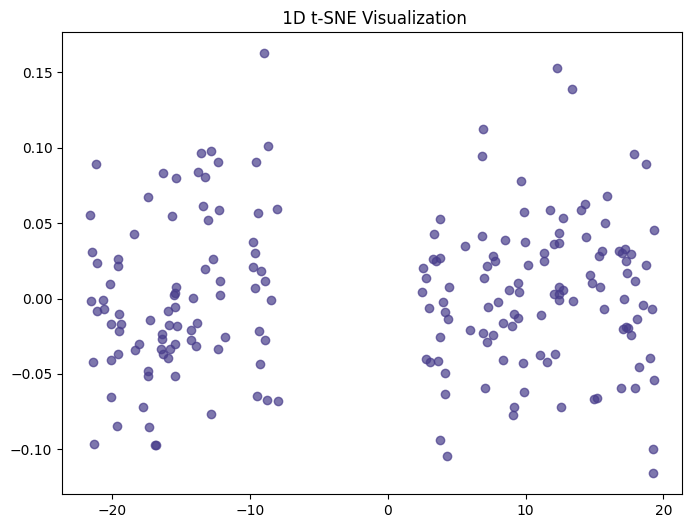

In [4925]:
plt.figure(figsize=(8, 6))
j = np.random.normal(0, 0.05, size=X_train_tsne.shape)
plt.scatter(X_train_tsne.flatten(),j.flatten(), alpha=0.7,color='#483D8B')
plt.title(' 1D t-SNE Visualization')
plt.show()

In [4926]:
tsne=TSNE(n_components=2,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_train_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.013268
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.666233
[t-SNE] KL divergence after 500 iterations: 0.172362


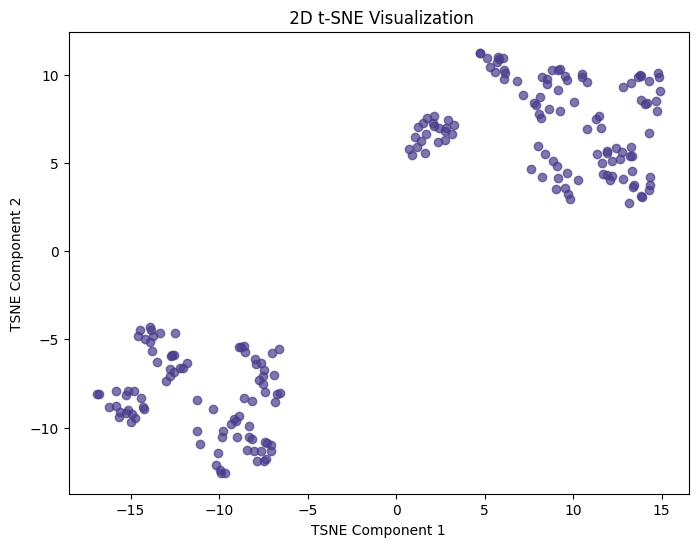

In [4927]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.7,color='#483D8B')
plt.title(' 2D t-SNE Visualization')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

In [4928]:
tsne=TSNE(n_components=3,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_train_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.013268
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.639641
[t-SNE] KL divergence after 500 iterations: 0.245136


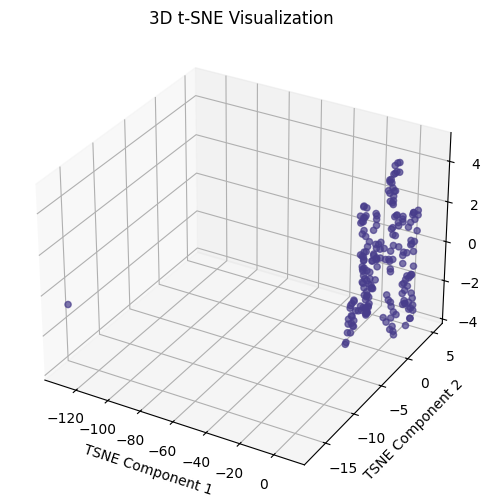

In [4929]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], alpha=0.7,color='#483D8B')
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
ax.set_zlabel('TSNE Component 3')

plt.show()

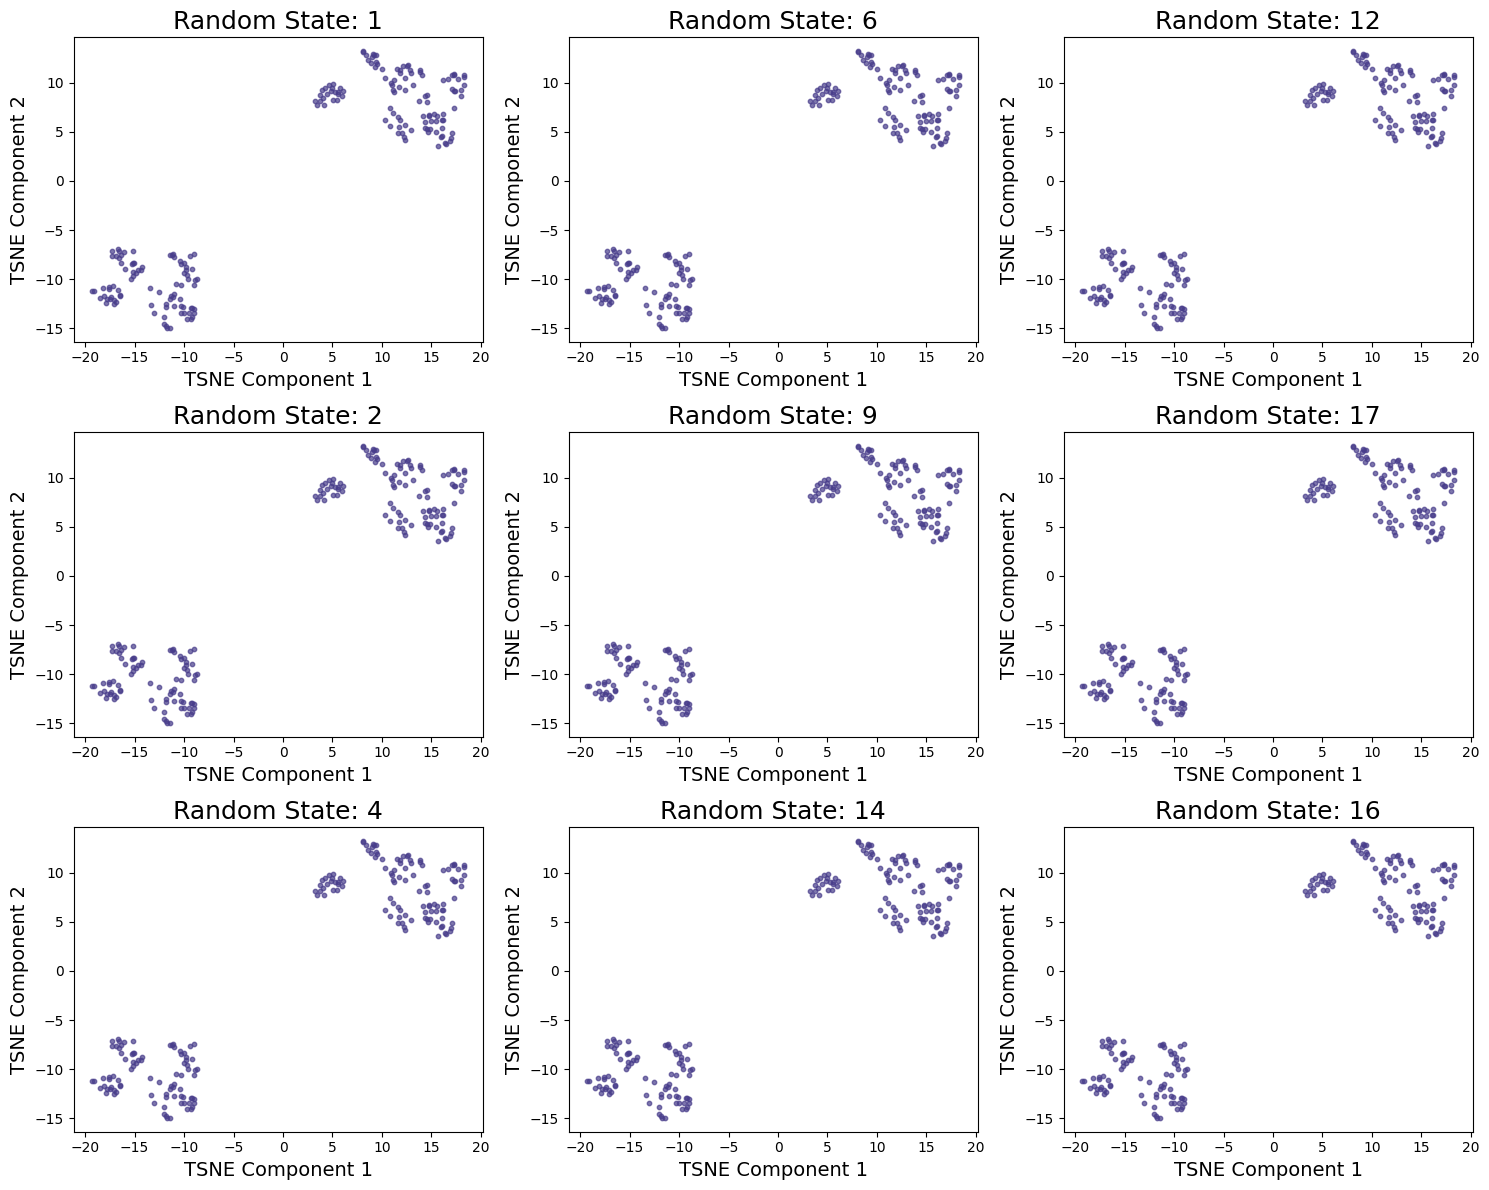

In [4930]:
np.random.seed(42)
random_states=np.random.choice(range(1, 20), size=9, replace=False)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for a,i in enumerate(random_states) :

    tsne1=TSNE(n_components=2, random_state=i, perplexity=30)
    X_train_tsne=tsne1.fit_transform(X_scaled)

    ax=axes[a]
    ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.7, color='#483D8B', s=10)
    ax.set_title(f'Random State: {i}', fontsize=18)
    ax.set_xlabel('TSNE Component 1', fontsize=14)
    ax.set_ylabel('TSNE Component 2', fontsize=14)
plt.tight_layout()
plt.show()

In [4931]:
tsne_baseline= TSNE(n_components=2, random_state=random_states[0], perplexity=30)
X_baseline= tsne_baseline.fit_transform(X_scaled)
mean_diffs = []
for i in random_states[1:]:
    tsne2=TSNE(n_components=2, random_state=i, perplexity=30)
    X_tsne=tsne2.fit_transform(X_scaled)


    diff = np.mean(np.abs(X_tsne - X_baseline))
    mean_diffs.append((i, diff))

print("Average coordinate difference:")
for state, diff in mean_diffs:
    print(f"Random State = {state}, Mean Difference = {diff:.4f}")

Average coordinate difference:
Random State = 6, Mean Difference = 0.0000
Random State = 12, Mean Difference = 0.0000
Random State = 2, Mean Difference = 0.0000
Random State = 9, Mean Difference = 0.0000
Random State = 17, Mean Difference = 0.0000
Random State = 4, Mean Difference = 0.0000
Random State = 14, Mean Difference = 0.0000
Random State = 16, Mean Difference = 0.0000


# **Kmeans**

**This code track memory usage and execution time of a process in a program**

In [4932]:
def track_memory():
  cu_mem=psutil.Process()
  start_time=time.time()
  return cu_mem,start_time
def print_memory_usage(cu_mem,start_time,model_name):
  end_time=time.time()
  memory_used=cu_mem.memory_info().rss/(1024**2)
  execution_time=end_time-start_time
  return memory_used,execution_time


track_memory() initializes a process monitor and captures the start time to measure resource usage.

print_memory_usage() calculates and returns the memory (in MB) and execution time (in seconds) used by a model or operation.

**1.Standard Kmeans:**

In [4933]:
cu_mem,start_time=track_memory()
model_1=KMeans(n_clusters=2,random_state=0,init='random')
model_1.fit(X_train_pca)
memory_used,execution_time=print_memory_usage(cu_mem,start_time,'model_1')
print("Execution Time:",execution_time)
print("Memory Usage in MB:",memory_used)
pridiction=model_1.predict(X_train_pca)

Execution Time: 0.009006977081298828
Memory Usage in MB: 1939.73046875


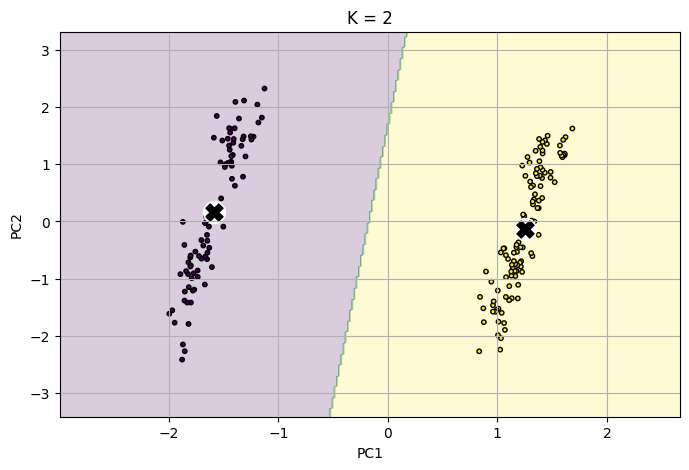

In [4934]:
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = model_1.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=model_1.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(model_1.cluster_centers_[:, 0], model_1.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(model_1.cluster_centers_[:, 0], model_1.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title("K = 2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

This plot shows the clustering result obtained using Standard KMeans with K=2,the dataset is partitioned into two clusters,visually represented by distinct colors and separated by a decision boundary ,eacht point's color corresponds to its cluster,
this visual segmentation alone does not confirm the clustering's optimality ,To further evaluate the quality of this clustering, we will now calculate the Inertia and Silhouette Score, which help determine whether this division is meaningful and well-separated.

In [4935]:
print("Inertia Value: ",model_1.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca, pridiction,random_state=42))

Inertia Value:  597.9472937932284
Silhouette Score: 0.39644160577705434


**The inertia value of ~597.396 indicates the total within-cluster variance, but by itself, it doesn't confirm the clustering quality. The silhouette score of ~0.398 suggests moderate separation between clusters, better than weak. It may not be ideal (since good scores are typically > 0.5), but it does not reflect poor clustering.**

In [4936]:
k_values = range(2,21)
inertia=[]
silhouette_scores={}
models={}

for k in k_values:
  kmeans=KMeans(n_clusters=k,random_state=42,init='random')
  kmeans.fit(X_train_pca)
  inertia.append(kmeans.inertia_)
  silhouette_scores[k]=silhouette_score(X_train_pca,kmeans.labels_,random_state=42)
  models[k]=kmeans

In [4937]:
#this cell aims to find the best k
kl = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow
print("Best k (Elbow Point) = ",best_k)

Best k (Elbow Point) =  8


This cell uses the KneeLocator to identify the best number of clusters by detecting the elbow point based on the inertia curve,it works by analyzing the curve of (number of clusters , inertia ) it detects the point of maximum curvature where the curve bends most sharply


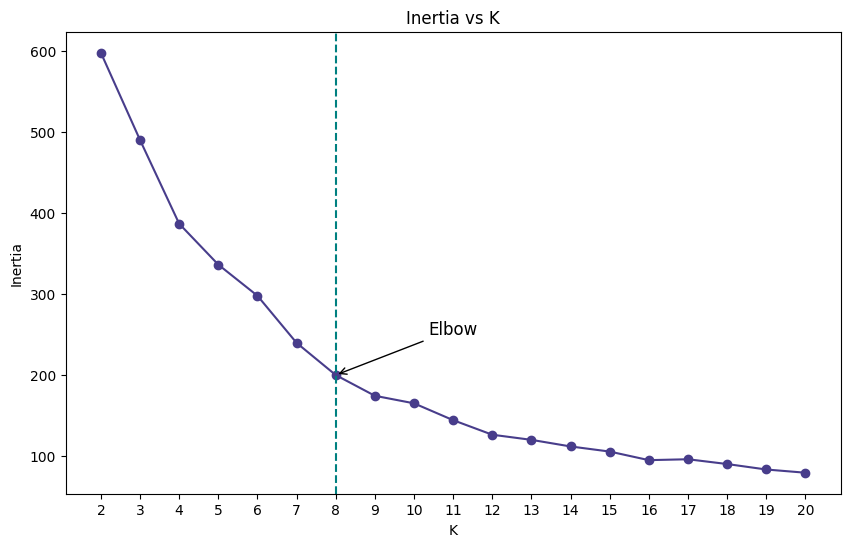

In [4938]:
plt.figure(figsize=(10,6))
plt.plot(k_values,inertia,marker='o',color='#483D8B')
plt.title('Inertia vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(k_values)
elbow_x = best_k
elbow_y = inertia[best_k -2]
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.annotate("Elbow",
             xy=(elbow_x, elbow_y),
             xytext=(elbow_x + 3, elbow_y+50),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             ha='center')
plt.show()

In [4939]:
kmeans11 = KMeans(n_clusters=best_k, random_state=0,init='random')
kmeans11.fit(X_train_pca)

train_clusters1=kmeans11.predict(X_train_pca)

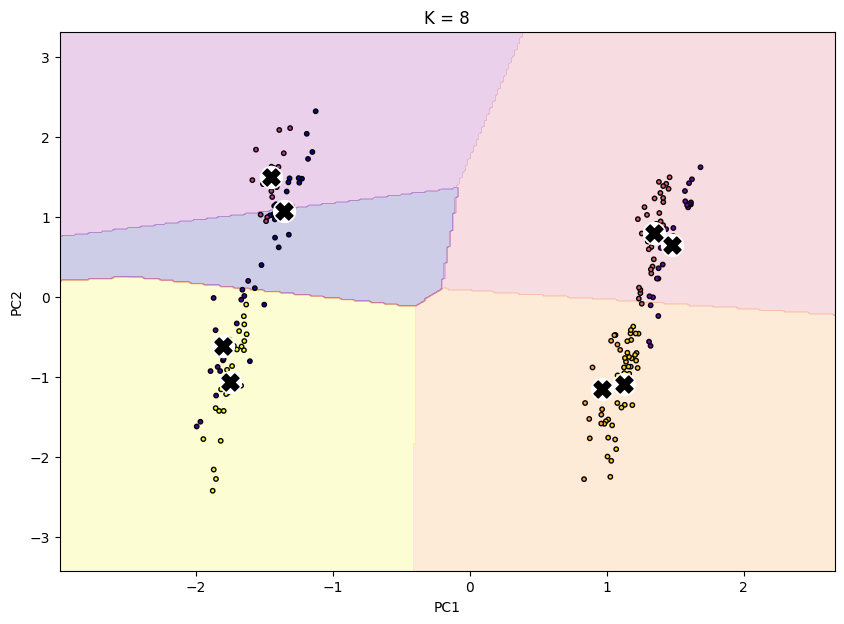

In [4940]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('plasma', 10)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = kmeans11.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans11.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(kmeans11.cluster_centers_[:, 0], kmeans11.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(kmeans11.cluster_centers_[:, 0], kmeans11.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title(f"K = {best_k}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

plt.show()

In [4941]:
print("Inertia Value: ",kmeans11.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca, train_clusters1,random_state=42))

Inertia Value:  205.89415425832752
Silhouette Score: 0.3848155802112954


In [4942]:
best_k_standard = max(silhouette_scores, key=silhouette_scores.get)
print("Best k based on Silhouette Score = ",best_k_standard)

Best k based on Silhouette Score =  12


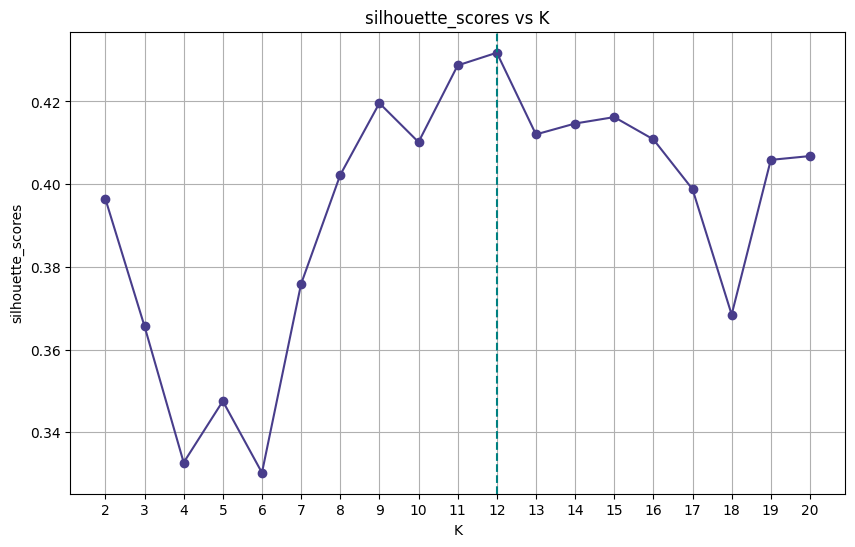

In [4943]:
plt.figure(figsize=(10,6))
plt.plot(list(silhouette_scores.keys()),list(silhouette_scores.values()),marker='o',color='#483D8B')
plt.title('silhouette_scores vs K')
plt.xlabel('K')
plt.xticks(k_values)
plt.ylabel('silhouette_scores')
plt.grid()

plt.axvline(best_k_standard, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.show()

This plot displays the Silhouette Score for different values of K (number of clusters).
The goal is to identify the value of K that yields the highest Silhouette Score, indicating the most well-defined clusters.

In this case, the peak score occurs at K = 12, suggesting that 12 is the optimal number of clusters for this dataset.

Conclusion:
Choosing K = 12 provides the best balance between intra-cluster similarity and inter-cluster separation, leading to better clustering performance.





In [4944]:
kmeans12 = KMeans(n_clusters=best_k_standard, random_state=0,init='random')
kmeans12.fit(X_train_pca)

train_clusters2=kmeans12.predict(X_train_pca)

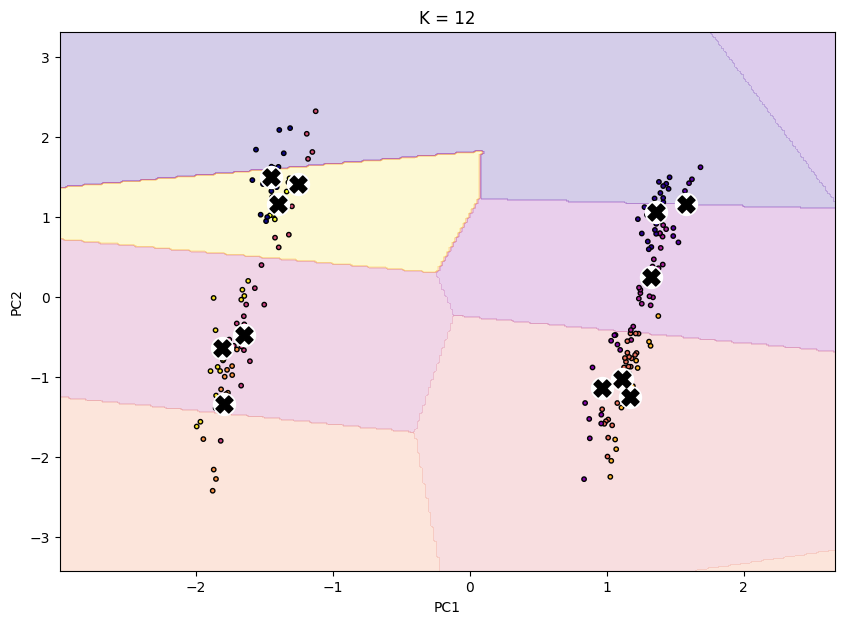

In [4945]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('plasma', 20)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = kmeans12.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans12.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(kmeans12.cluster_centers_[:, 0], kmeans12.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(kmeans12.cluster_centers_[:, 0], kmeans12.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title(f"K = {best_k_standard}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
#ax.grid()
plt.show()

In [4946]:
print("Inertia Value: ",kmeans12.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca, train_clusters2,random_state=42))

Inertia Value:  131.1025646034866
Silhouette Score: 0.41074027973582844


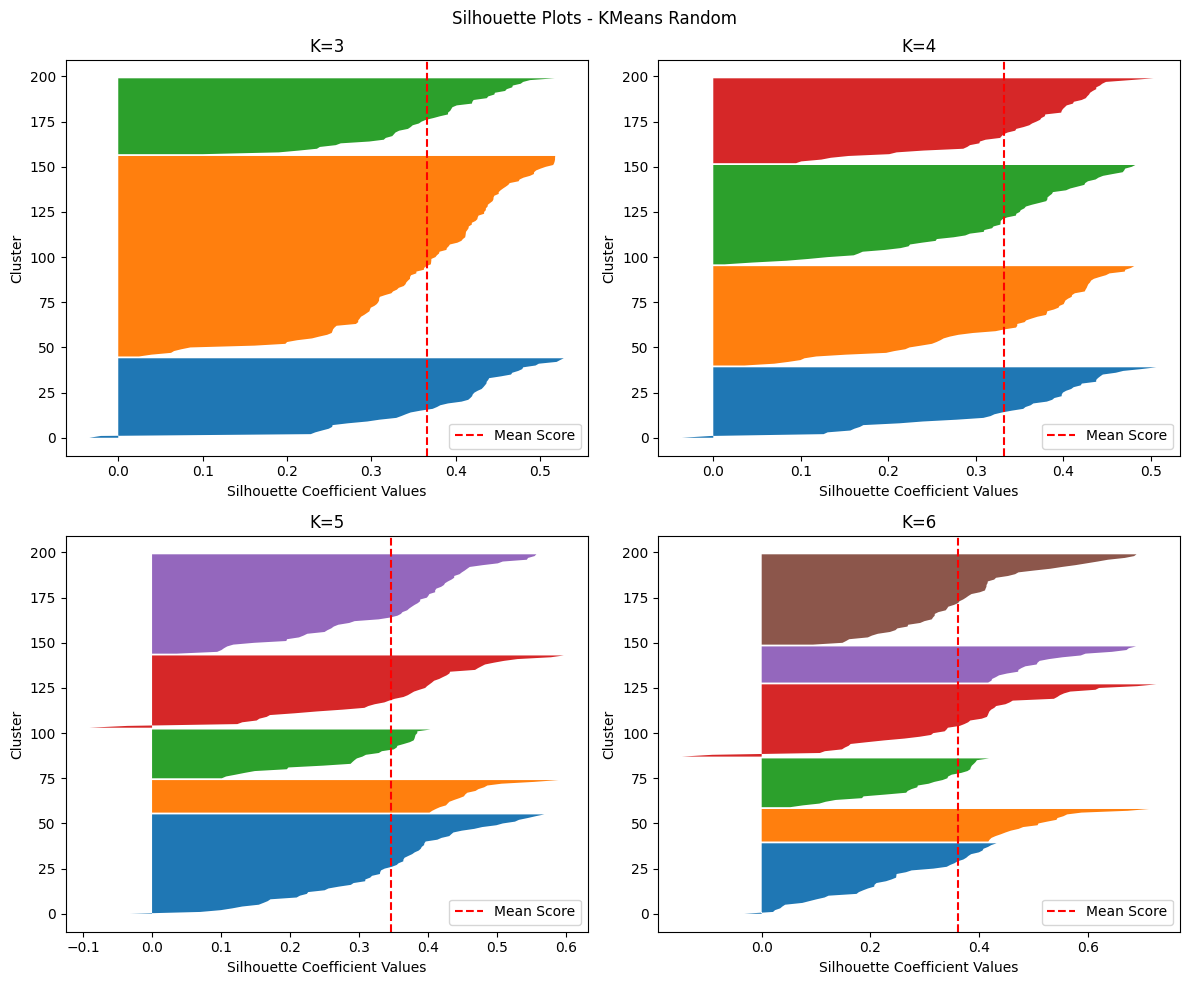

In [4947]:

def plot_silhouette(ax, X, labels, title):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0
    sorted_silhouette_vals = np.sort(silhouette_vals)

    for i in range(len(np.unique(labels))):
        ith_cluster_silhouette_vals = sorted_silhouette_vals[labels == i]
        y_upper += len(ith_cluster_silhouette_vals)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals)
        y_lower = y_upper

    ax.axvline(np.mean(silhouette_vals), color="red", linestyle="--", label="Mean Score")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster")
    ax.set_title(title)
    ax.legend()


k_values = [3, 4, 5, 6]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Silhouette Plots - KMeans Random")

for ax, k in zip(axes.flatten(), k_values):
    kmeans = KMeans(n_clusters=k, init='random', random_state=7, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_train_pca)
    plot_silhouette(ax, X_train_pca, kmeans_labels, f"K={k}")

plt.tight_layout()
plt.show()

**Silhouette Analysis Summary :**

This plot shows the Silhouette Coefficients for different values of **k** (number of clusters). Each subplot corresponds to a different value of `k`, and visualizes the silhouette score distribution across the clusters.

#### Key Observations:
- The **red dashed line** represents the **average silhouette score** for each `k`.
- A **higher average silhouette score** indicates better-defined clusters.
- When:
  - **k = 2 or 3**: Clusters appear more compact and separated.
  - **k = 5 and beyond**: Many clusters have silhouette scores near 0 or even negative, indicating overlapping or poorly separated clusters.
- **k = 3 to 5** may be reasonable choices for clustering, as they show a better balance between compactness and separation.

#### What is Silhouette Score?
It ranges from -1 to 1:
- Close to **1** → well-clustered, far from neighboring clusters.
- Close to **0** → on the border of two clusters.
- Close to **-1** → possibly assigned to the wrong cluster.

This analysis helps in choosing the **optimal `k`** by looking for the highest average silhouette score with consistently high individual cluster scores.


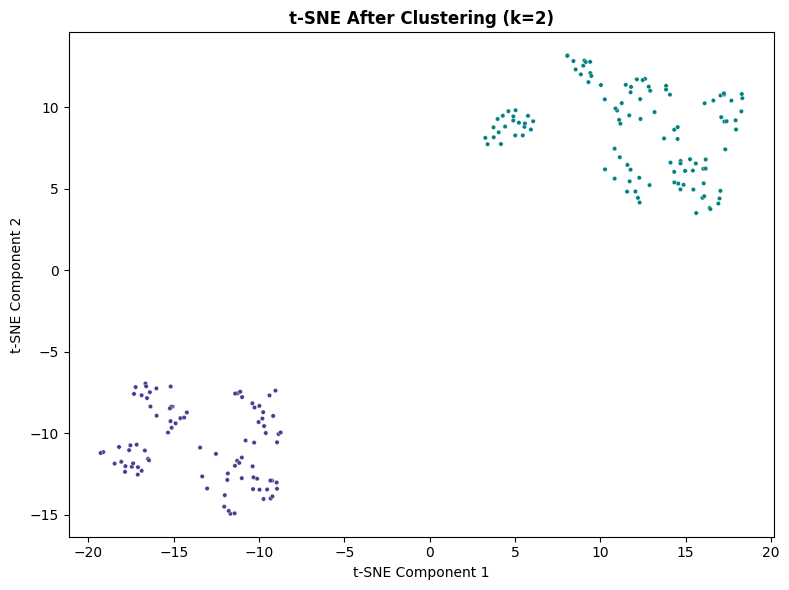

In [4948]:
kmeans=KMeans(n_clusters=2,random_state=0,init='random')
kmeans.fit(X_train_tsne)

plt.figure(figsize=(8,6))

label=kmeans.predict(X_train_tsne)
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=label, palette=['#483D8B','#008080'], s=10, legend=None)
plt.title(f"t-SNE After Clustering (k={2})",  fontweight="bold")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

t-SNE visualization after applying Standard K-Means clustering with
𝑘
=
2
k=2. The plot shows the distribution of data points reduced to two dimensions using t-SNE, capturing the complex structure of the original dimensional space. The two clusters are colored differently, highlighting the separation achieved through the improved K-Means++ initialization, which helps in faster convergence and better clustering quality.

In [4949]:
kmeans_full=KMeans(n_clusters=best_k_standard,random_state=42,init="random")
kmeans_full.fit(X_scaled)
train_clusters_full=kmeans_full.predict(X_scaled)

In [4950]:
inertia_scaled = kmeans_full.inertia_
silhouette_scaled = silhouette_score(X_scaled, train_clusters_full, random_state=42)
print("Inertia Value: ",inertia_scaled)
print("Silhouette Score:",silhouette_scaled)

Inertia Value:  126.01641418723081
Silhouette Score: 0.43179412920099497


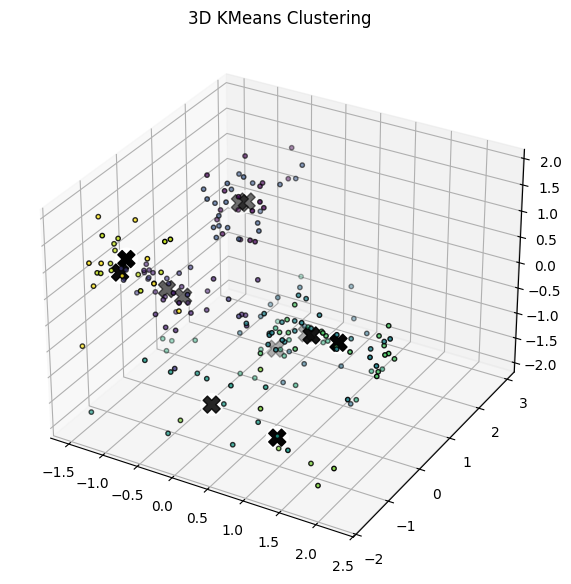

In [4951]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=kmeans_full.labels_, cmap='viridis', s=10, edgecolor='k')

ax.scatter(kmeans_full.cluster_centers_[:, 0], kmeans_full.cluster_centers_[:, 1], kmeans_full.cluster_centers_[:, 2],
           c='white', marker='o', s=250)
ax.scatter(kmeans_full.cluster_centers_[:, 0], kmeans_full.cluster_centers_[:, 1], kmeans_full.cluster_centers_[:, 2],
           c='black', marker='X', s=150)
ax.set_title("3D KMeans Clustering")
ax.grid(True)

plt.show()

Comparing clustering performance with and without dimensioality reduction(PCA)

In [4952]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [4953]:
kmeans_2d=MiniBatchKMeans(n_clusters=best_k_standard,random_state=42,init="random")
clusterspca= kmeans_2d.fit_predict(X_pca)

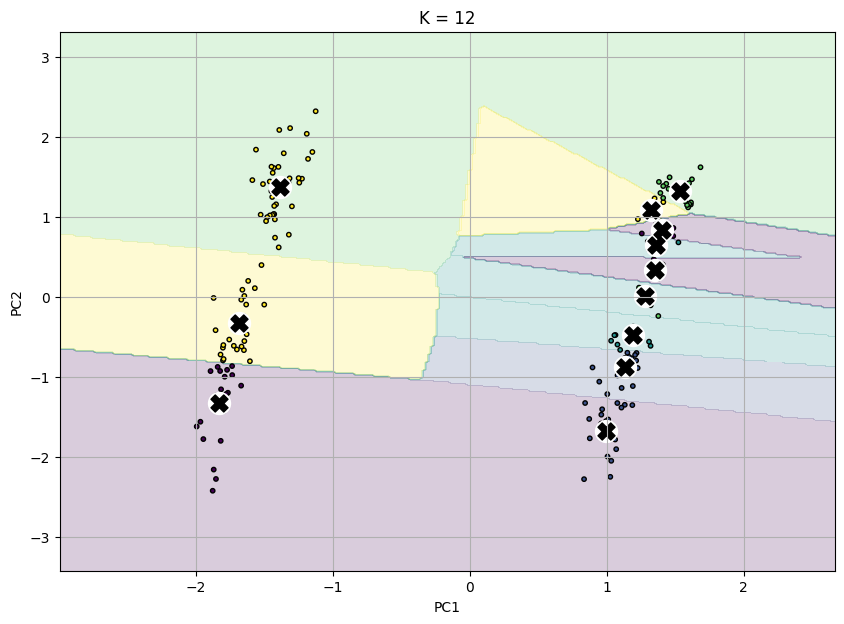

In [4954]:
h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = kmeans_2d.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_2d.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(kmeans_2d.cluster_centers_[:, 0], kmeans_2d.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(kmeans_2d.cluster_centers_[:, 0], kmeans_2d.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title(f"K = {best_k_standard}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

**2.Kmeans++:**

In [4955]:
cu_mem,start_time=track_memory()
model_2=KMeans(n_clusters=2,random_state=4,init='k-means++')
model_2.fit(X_train_pca)
memory_usedP,execution_timeP=print_memory_usage(cu_mem,start_time,'model_2')
pridiction_P=model_2.predict(X_train_pca)
print("Execution Time:",execution_time)
print("Memory Usage in MB:",memory_used)

Execution Time: 0.009006977081298828
Memory Usage in MB: 1939.73046875


In [4956]:
print("Inertia Value: ",model_2.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca, pridiction_P,random_state=42))

Inertia Value:  597.9472937932284
Silhouette Score: 0.39644160577705434


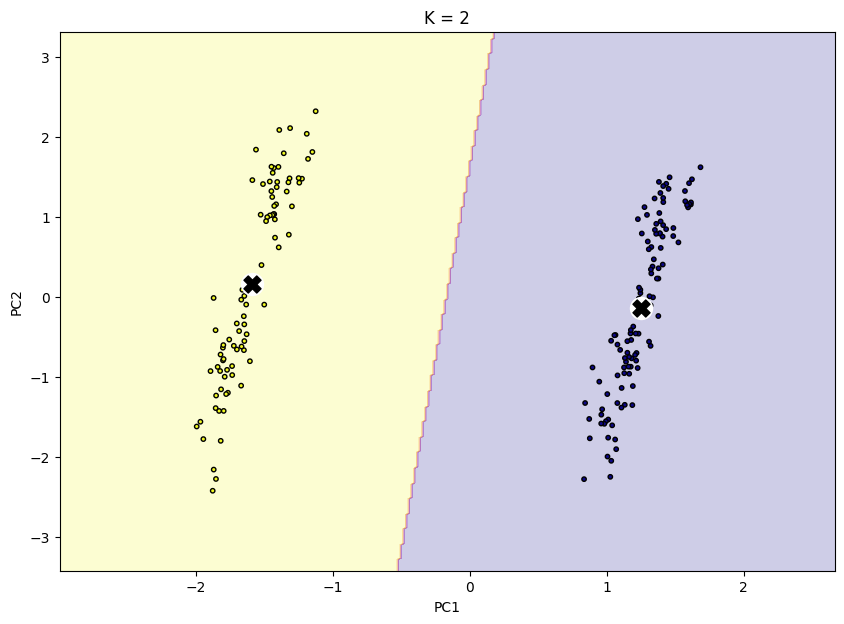

In [4957]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('plasma', 5)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = model_2.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=model_2.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(model_2.cluster_centers_[:, 0], model_2.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(model_2.cluster_centers_[:, 0], model_2.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title("K = 2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
#ax.grid()
plt.show()

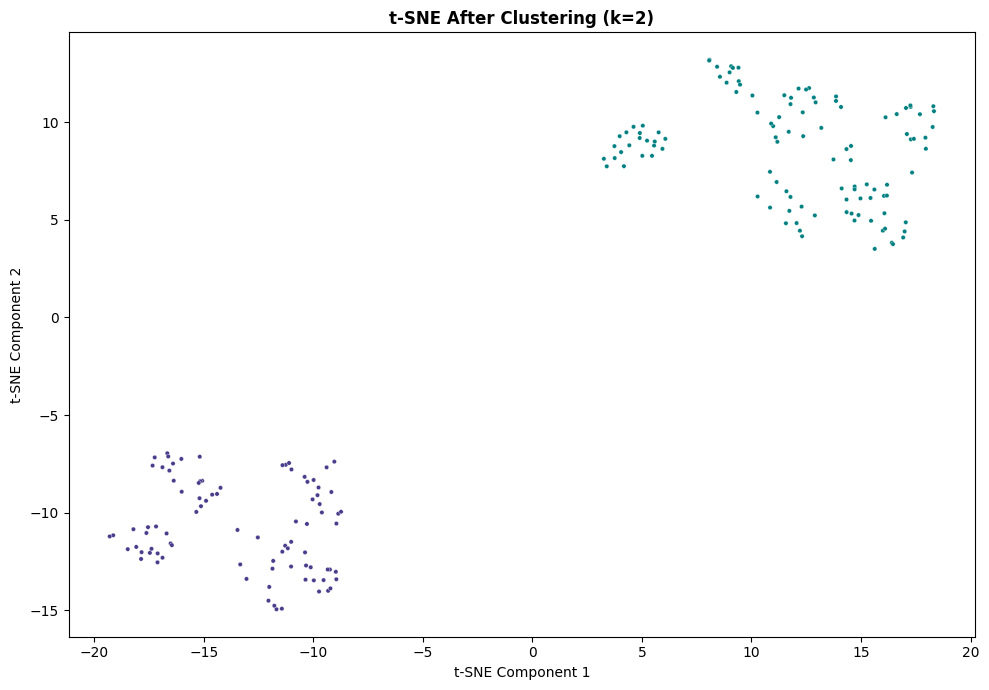

In [4958]:
kmeansP=KMeans(n_clusters=2,random_state=42,init='k-means++')
kmeansP.fit(X_train_tsne)

plt.figure(figsize=(10,7))

label=kmeansP.predict(X_train_tsne)
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=label, palette=['#483D8B','#008080'], s=10, legend=None)
plt.title(f"t-SNE After Clustering (k={2})",  fontweight="bold")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

In [4959]:
k_values = range(2,21)
inertia=[]
silhouette_scores={}
models={}

for k in k_values:
  kmeans=KMeans(n_clusters=k,random_state=42,init='k-means++')
  kmeans.fit(X_train_pca)
  inertia.append(kmeans.inertia_)
  silhouette_scores[k]=silhouette_score(X_train_pca,kmeans.labels_,sample_size=10000,random_state=42)
  models[k]=kmeans
kl = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow
print("Best k (Elbow Point) = ",best_k)

Best k (Elbow Point) =  10


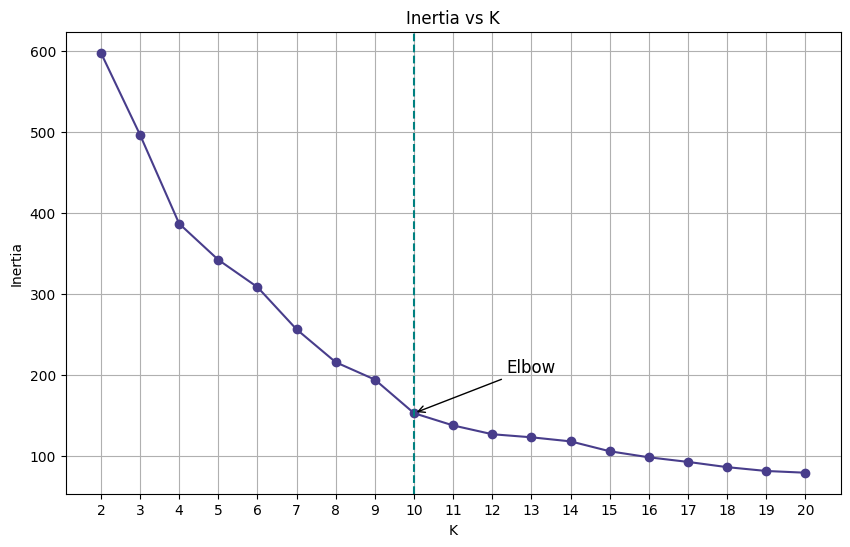

In [4960]:
plt.figure(figsize=(10,6))
plt.plot(k_values,inertia,marker='o',color='#483D8B')
plt.title('Inertia vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()

elbow_x = best_k
elbow_y = inertia[best_k -2]
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.annotate("Elbow",
             xy=(elbow_x, elbow_y),
             xytext=(elbow_x + 3, elbow_y+50),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             ha='center')
plt.show()

In [4961]:
kmeansP2=KMeans(n_clusters=best_k,random_state=42,init='k-means++')
kmeansP2.fit(X_train_pca)

KMeans(n_clusters=10, random_state=42)

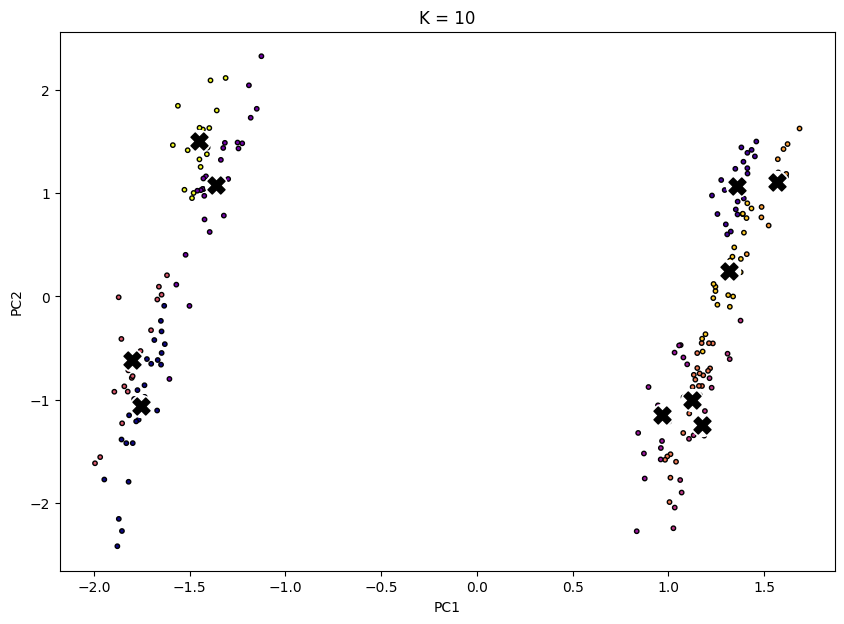

In [4962]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('plasma', 10)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = kmeansP2.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
#ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeansP2.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(kmeansP2.cluster_centers_[:, 0], kmeansP2.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(kmeansP2.cluster_centers_[:, 0], kmeansP2.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title(f"K = {best_k}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
#ax.grid()
plt.show()

In [4963]:
best_k_pp = max(silhouette_scores, key=silhouette_scores.get)
print("Best k based on Silhouette Score = ",best_k_pp)

Best k based on Silhouette Score =  11


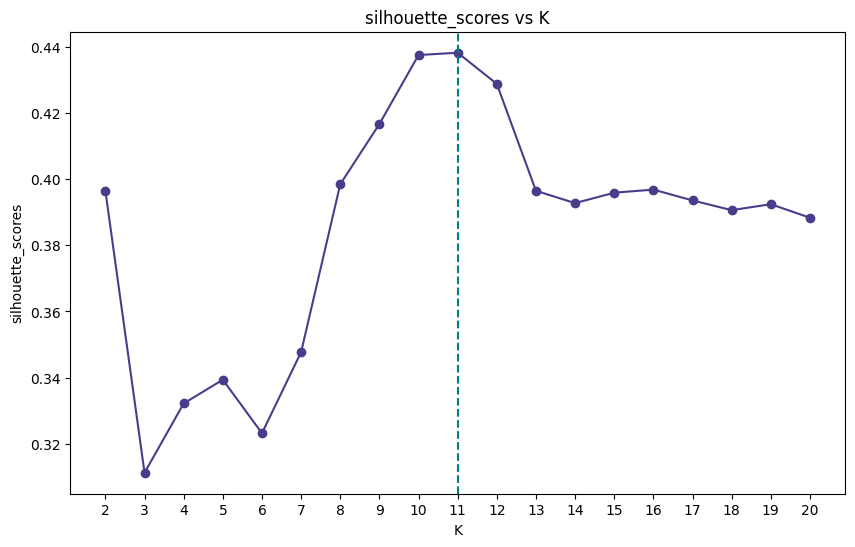

In [4964]:
plt.figure(figsize=(10,6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o',color='#483D8B')
plt.title('silhouette_scores vs K')
plt.xlabel('K')
plt.xticks(k_values)
plt.ylabel('silhouette_scores')
plt.axvline(best_k_pp, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.show()

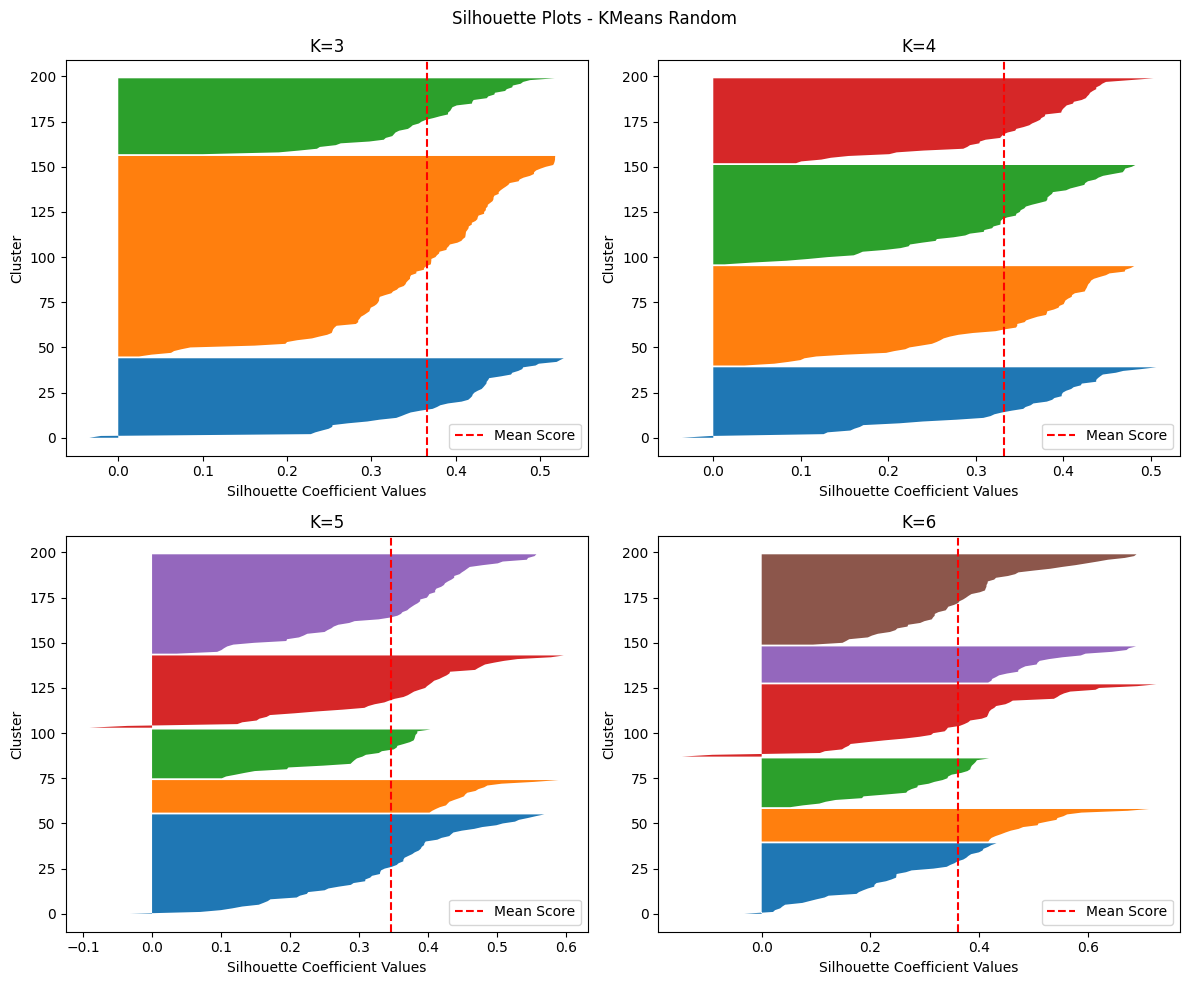

In [4965]:

def plot_silhouette(ax, X, labels, title):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0
    sorted_silhouette_vals = np.sort(silhouette_vals)

    for i in range(len(np.unique(labels))):
        ith_cluster_silhouette_vals = sorted_silhouette_vals[labels == i]
        y_upper += len(ith_cluster_silhouette_vals)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals)
        y_lower = y_upper

    ax.axvline(np.mean(silhouette_vals), color="red", linestyle="--", label="Mean Score")
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster")
    ax.set_title(title)
    ax.legend()


k_values = [3, 4, 5, 6]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Silhouette Plots - KMeans Random")

for ax, k in zip(axes.flatten(), k_values):
    kmeans = KMeans(n_clusters=k, init='random', random_state=7, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_train_pca)
    plot_silhouette(ax, X_train_pca, kmeans_labels, f"K={k}")

plt.tight_layout()
plt.show()

# Create subplots for K-Means++ Initialization


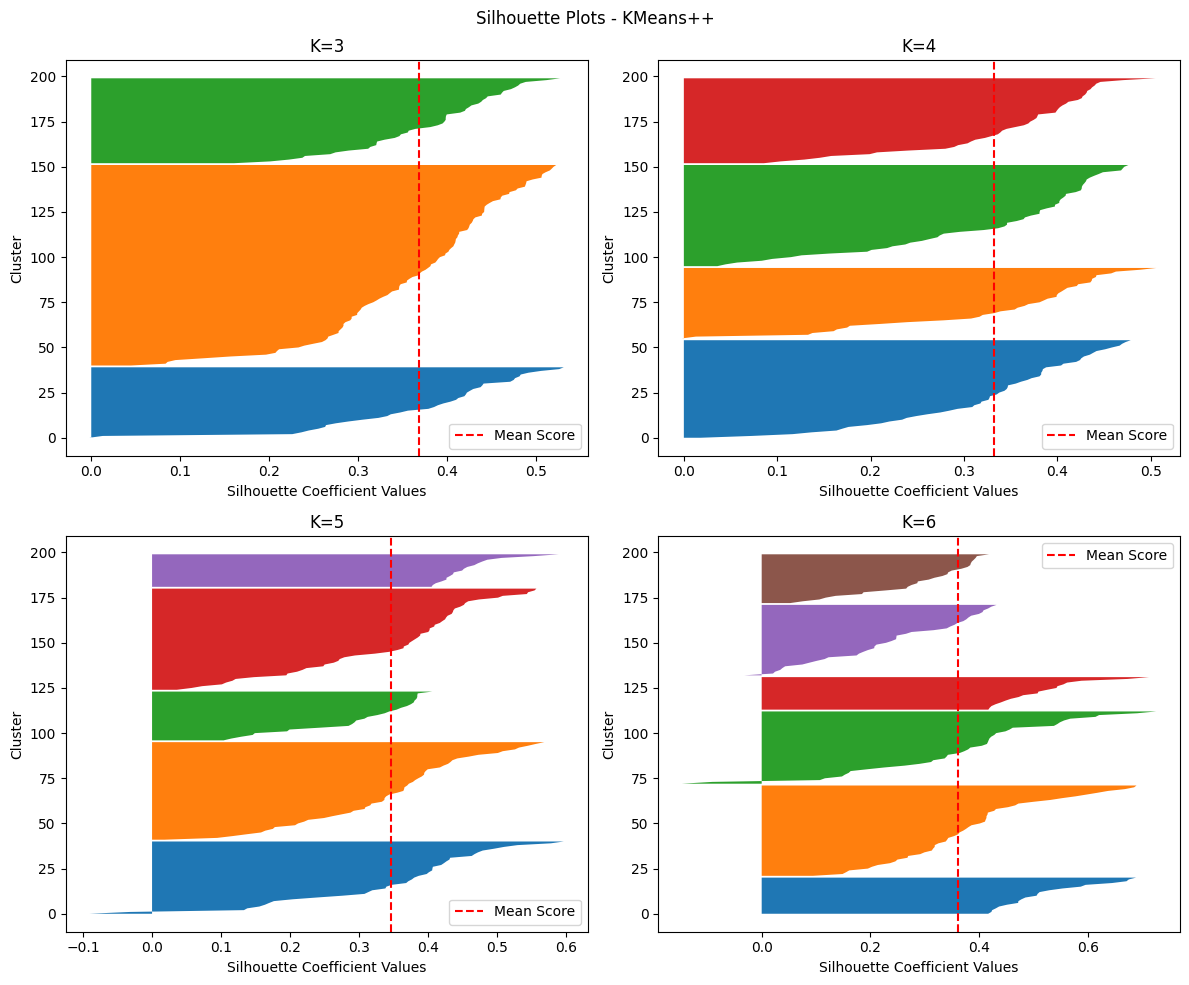

In [4966]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Silhouette Plots - KMeans++")

for ax, k in zip(axes.flatten(), k_values):
    kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=7, n_init=10)
    kmeans_plus_labels = kmeans_plus.fit_predict(X_train_pca)
    plot_silhouette(ax, X_train_pca, kmeans_plus_labels, f"K={k}")

plt.tight_layout()
plt.show()

Compare standard KMeans and KMeans++:

In [4967]:
SK_VS_KP=pd.DataFrame({'Metric':["Inertia", "Silhouette Score","Iterations","Execution Time"],
          'Standard KMeans':[model_1.inertia_,silhouette_score(X_train_pca, pridiction,random_state=42),model_1.n_iter_,execution_time],
          'KMeans Plus Plus':[model_2.inertia_,silhouette_score(X_train_pca, pridiction_P,random_state=42),model_2.n_iter_,execution_timeP]})
SK_VS_KP

Metric  Standard KMeans  KMeans Plus Plus
0           Inertia       597.947294        597.947294
1  Silhouette Score         0.396442          0.396442
2        Iterations         3.000000          4.000000
3    Execution Time         0.009007          0.005433

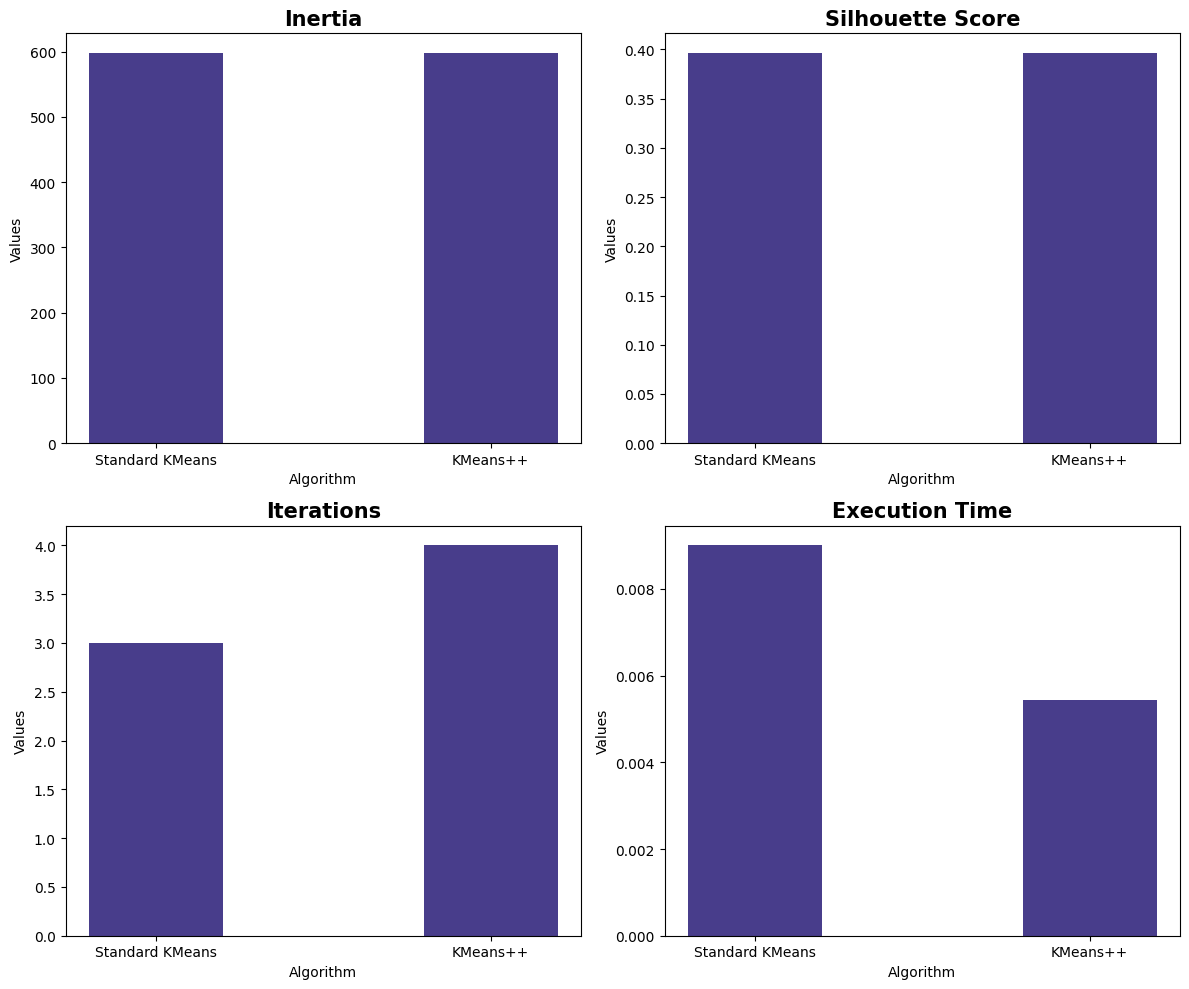

In [4968]:
fig,ax=plt.subplots(2,2,figsize=(12,10))
metrics = SK_VS_KP["Metric"]
for i,ax in enumerate(ax.flatten()):
    metric= metrics[i]
    values= SK_VS_KP.loc[SK_VS_KP["Metric"] == metric].iloc[0, 1:]
    labels= ["Standard KMeans", "KMeans++"]
    ax.bar(labels, values, width=.4,color='#483D8B')
    ax.set_title(metric, fontsize=15, fontweight="bold")
    ax.set_ylabel("Values")
    ax.set_xlabel("Algorithm")
    ax.tick_params(axis="x")
    ax.tick_params(axis="y")
plt.tight_layout()
plt.show()

KMeans++ may take more iterations than the Standard KMean

But the Execution time for is lower than the standard KMean

KMeans++ generally converges in fewer iterations due to smarter initialization, but the initialization step is more computationally expensive. This can result in longer total runtime despite faster convergence.



1.  **Interia** :

  *  Standard KMeans:
      *   Higher inertia
      *   indicates less compact clusters
  
  *  KMeans++
      *  Lower inertia
      *   Produces more compact and better-formed clusters
  
  *   conclusion: KMeans++ preforms better in minimizing inertia

2.   **Silhouette Score**

  *   Standard KMeans:
      *   Lower sihouette score
      *   Clusters are less well separated

  *   KMeans++:

      *   Higher silhouette score
      *   Clusters are more distinct and clearly separated
  
  *   Conclusion: KMeans++ results in higher cluster quality

3.   **Iterations to Converge**
  
  *   Standard KMeans:

      *   Fewer iterations

  *   KMeans++:

      *   Slightly more iterations

  *   Conclusion: Standard KMeans converges faster in steps, but not necessarily to a better solution
4.   Execution Time

  *   Standard KMeans:

      *   Slightly slower

  *   KMeans++:

      *   Slightly faster

  *   Conclusion: KMeans++ is marginally more efficient in runtime













In [4969]:
exp=15
comparisonss=[]
Comparisons={
    "Random State":[],
    "Inertia":[],
    "Silhouette Score":[],
    "Iterations":[],
    "Execution Time":[]
}
for i in range(exp):
    random_state = np.random.randint(0, 10000)
    Stime= time.time()
    kmeanspp= KMeans(n_clusters=2, init="k-means++", random_state=random_state)
    clusterspp= kmeanspp.fit_predict(X_train_pca)
    Etime= time.time()
    Comparisons["Random State"].append(random_state)
    Comparisons["Inertia"].append(kmeanspp.inertia_)
    Comparisons["Silhouette Score"].append(silhouette_score(X_train_pca, clusterspp, sample_size=50, random_state=42))
    Comparisons["Iterations"].append(kmeanspp.n_iter_)
    Comparisons["Execution Time"].append(Etime - Stime)


final_comparisons = pd.DataFrame(Comparisons)
final_comparisons

Random State     Inertia  Silhouette Score  Iterations  Execution Time
0           2433  597.947294          0.410429           2        0.005363
1           5311  597.947294          0.410429           3        0.001838
2           5051  788.219165          0.210791           7        0.001881
3           6420  597.947294          0.410429           2        0.001561
4           1184  597.947294          0.410429           3        0.001597
5           4555  597.947294          0.410429           3        0.001669
6           3385  597.947294          0.410429           2        0.001503
7           6396  597.947294          0.410429           3        0.001584
8           8666  597.947294          0.410429           3        0.001506
9           9274  597.947294          0.410429           2        0.001510
10          2558  597.947294          0.410429           3        0.001528
11          7849  597.947294          0.410429           4        0.001587
12          2047  597.947294          0.410429           2        0.001544
13          2747  597.947294          0.410429           3        0.001582
14          9167  597.947294          0.410429           3        0.001561

Comparing clustering performance with and without dimensioality reduction(PCA)

1-with dimensioality reduction(PCA)

In [4970]:
Kmeansp_pca=KMeans(n_clusters=2,random_state=42,init='k-means++')
clustesppc=Kmeansp_pca.fit(X_train_pca)

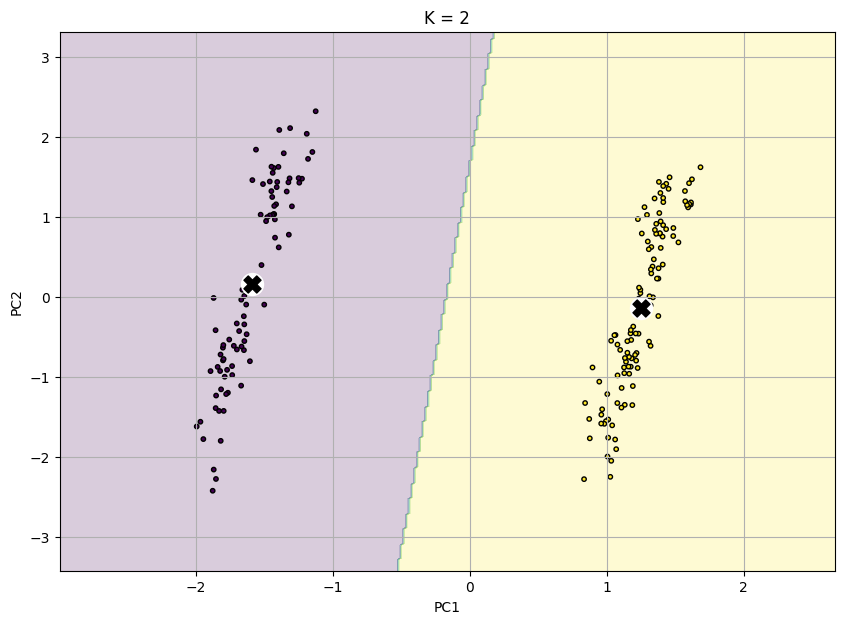

In [4971]:
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = Kmeansp_pca.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Kmeansp_pca.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(Kmeansp_pca.cluster_centers_[:, 0], Kmeansp_pca.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(Kmeansp_pca.cluster_centers_[:, 0], Kmeansp_pca.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title("K = 2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

In [4972]:
print("Inertia Value: ",Kmeansp_pca.inertia_)
print("Silhouette Score:",silhouette_score(X_train_pca,clusterspp,random_state=42))

Inertia Value:  597.9472937932284
Silhouette Score: 0.39644160577705434


2-without dimensioality reduction(PCA)

In [4973]:
kmeans_ppp=KMeans(n_clusters=2,random_state=42,init='k-means++')
clusterss=kmeans_ppp.fit(X_scaled)
kpp=kmeans_ppp.predict(X_scaled)

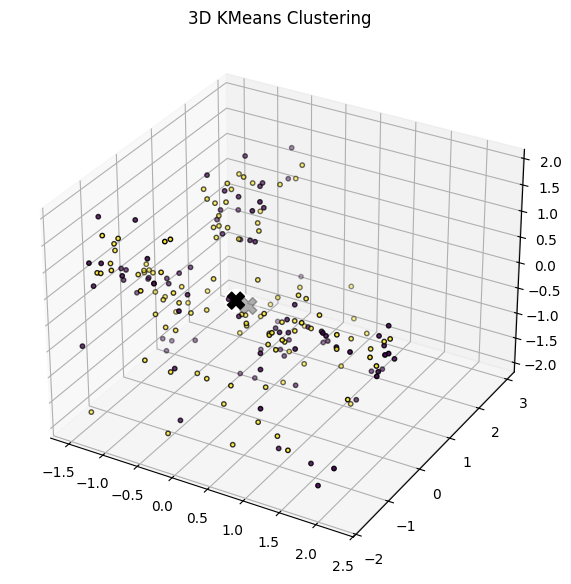

In [4974]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=kmeans_ppp.labels_, cmap='viridis', s=10, edgecolor='k')

ax.scatter(kmeans_ppp.cluster_centers_[:, 0], kmeans_ppp.cluster_centers_[:, 1], kmeans_ppp.cluster_centers_[:, 2],
           c='white', marker='o', s=250)
ax.scatter(kmeans_ppp.cluster_centers_[:, 0], kmeans_ppp.cluster_centers_[:, 1], kmeans_ppp.cluster_centers_[:, 2],
           c='black', marker='X', s=150)
ax.set_title("3D KMeans Clustering")
ax.grid(True)

plt.show()

In [4975]:
print("Inertia Value: ",kmeans_ppp.inertia_)
print("Silhouette Score:",silhouette_score(X_scaled,kpp,random_state=42))

Inertia Value:  597.9472937932284
Silhouette Score: 0.3964416057770544


**Compare clustering in full space vs. reduced 2D space:**

In [4976]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [4977]:
kmeanspca2= KMeans(n_clusters=2, init='k-means++', random_state=42)
clusterspca= kmeanspca2.fit_predict(X_pca)

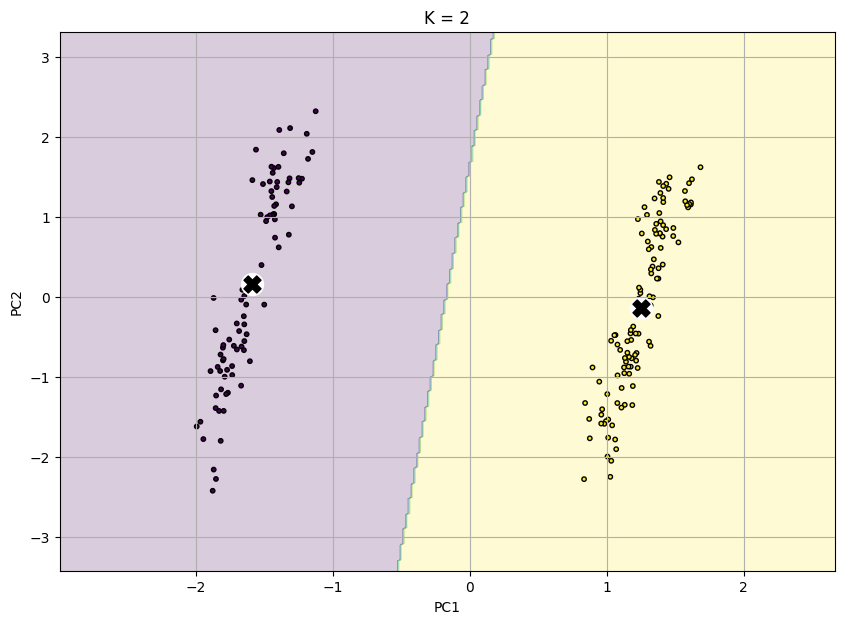

In [4978]:
h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = kmeanspca2.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeanspca2.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(kmeanspca2.cluster_centers_[:, 0], kmeanspca2.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(kmeanspca2.cluster_centers_[:, 0], kmeanspca2.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title("K = 2")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

In [4979]:
print("Inertia Value: ",kmeanspca2.inertia_)
print("Silhouette Score:",silhouette_score(X_pca,clusterspca,random_state=42))

Inertia Value:  265.80793167866943
Silhouette Score: 0.5917646144799474


 **3.Mini-Batch K-Means:**

In [4980]:
cu_mem,start_time=track_memory()
min_batch=MiniBatchKMeans(n_clusters=2,random_state=42,init="random")
min_batch.fit(X_train_pca)
memory_used_m,execution_time_m=print_memory_usage(cu_mem,start_time,'min_batch')
print("Execution Time:",execution_time)
print("Memory Usage in MB:",memory_used)
train_clusters=min_batch.predict(X_train_pca)

Execution Time: 0.009006977081298828
Memory Usage in MB: 1939.73046875


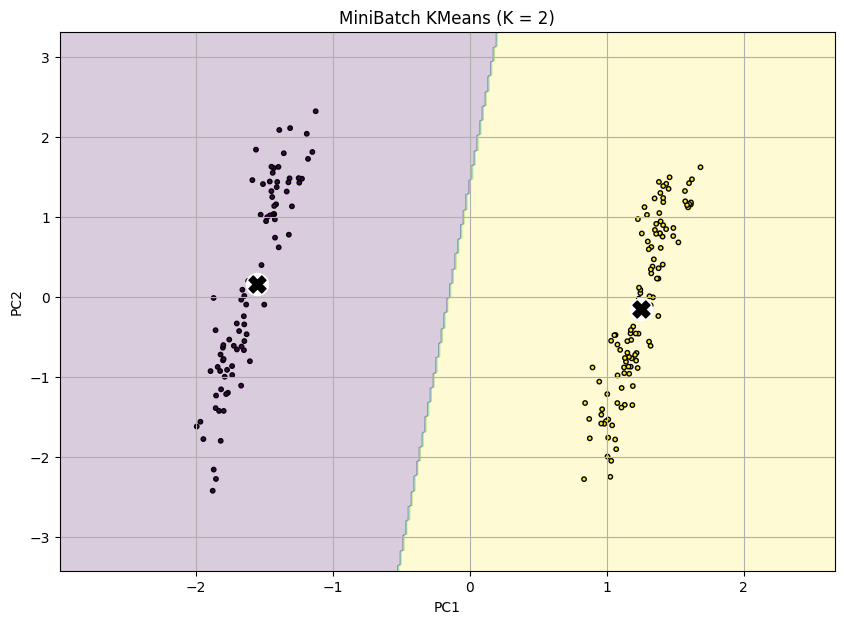

In [4981]:
h = 0.02
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_train_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = min_batch.predict(grid).reshape(xx.shape)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap=cmap, s=10, edgecolor='k')
ax.scatter(min_batch.cluster_centers_[:, 0], min_batch.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(min_batch.cluster_centers_[:, 0], min_batch.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title("MiniBatch KMeans (K = 2)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

In [4982]:
cluster_range = range(2,21)
inertia=[]
silhouette_scores=[]
models2={}

for k in cluster_range:
  min_batch=MiniBatchKMeans(n_clusters=k,random_state=42)
  min_batch.fit(X_train_pca)
  inertia.append(min_batch.inertia_)
  silhouette_scores.append(silhouette_score(X_train_pca,min_batch.labels_,random_state=42))
  models2[k]=min_batch

#aims to find the best k
kl = KneeLocator(cluster_range, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow
print("Best k (Elbow Point) = ",best_k)

Best k (Elbow Point) =  8


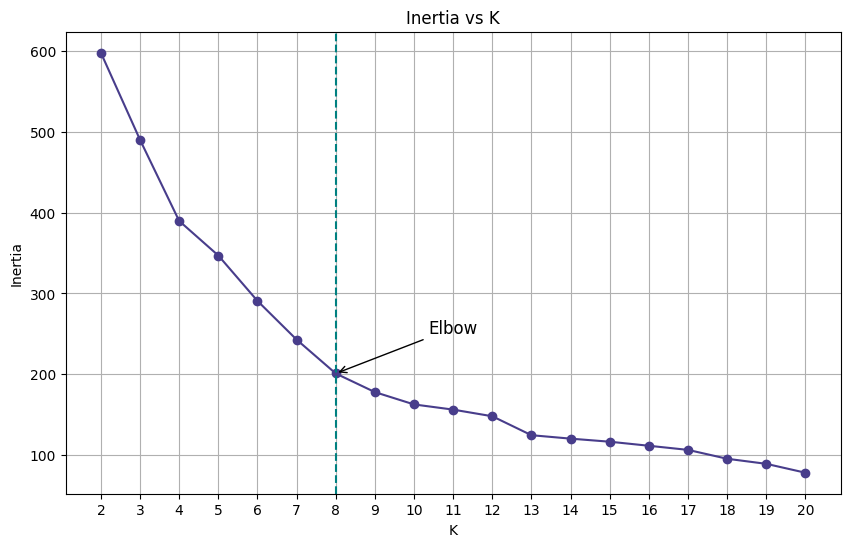

In [4983]:
plt.figure(figsize=(10,6))
plt.plot(cluster_range,inertia,marker='o',color='#483D8B')
plt.title('Inertia vs K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid()
elbow_x = best_k
elbow_y = inertia[best_k -2]
plt.axvline(best_k, color='#008080', linestyle='--', label=f"Best k = {best_k}")
plt.annotate("Elbow",
             xy=(elbow_x, elbow_y),
             xytext=(elbow_x + 3, elbow_y+50),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             ha='center')
plt.show()

In [4984]:
best_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
print("Best k based on Silhouette Score = ", best_k_silhouette)

Best k based on Silhouette Score =  13


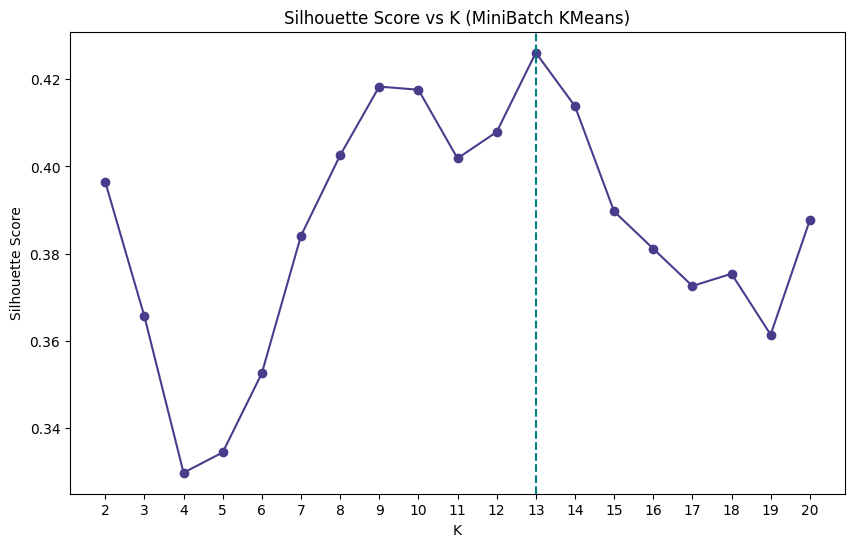

In [4985]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='#483D8B')
plt.title('Silhouette Score vs K (MiniBatch KMeans)')
plt.xlabel('K')
plt.xticks(cluster_range)
plt.ylabel('Silhouette Score')
plt.axvline(best_k_silhouette, color='#008080', linestyle='--', label=f"Best k = {best_k_silhouette}")
plt.show()


In [4986]:
best_k_mini = best_k_silhouette
best_k_mini

13

In [4987]:
mini_batch_best = MiniBatchKMeans(n_clusters=best_k_mini,random_state=42,init="random")
train_cluster = mini_batch_best.fit_predict(X_pca)

kmeanspp_best = KMeans(n_clusters=best_k_pp,random_state=4,init='k-means++')
pridiction_P = kmeanspp_best.fit_predict(X_pca)

Kmeans_best = KMeans(n_clusters=best_k_standard,random_state=0,init='random')
prediction = Kmeans_best.fit_predict(X_train_pca)

**Compare Standard KMeans and KMeans++ and Mini Batch Kmeans with each the nummber of clusters that we got from the silhouettte score for each model.**

In [4988]:
MB_VS_KP_VS_SK=pd.DataFrame({'Metric':["Inertia", "Silhouette Score","Iterations","Execution Time","Memory Usage"],
          'Standard KMeans':[Kmeans_best.inertia_,silhouette_score(X_train_pca, pridiction,random_state=42),Kmeans_best.n_iter_,execution_time,memory_used],
          'MiniBatch KMeans':[mini_batch_best.inertia_,silhouette_score(X_train_pca, train_clusters,random_state=42),mini_batch_best.n_iter_,execution_time_m,memory_used_m],
          'KMeans plus plus ':[kmeanspp_best.inertia_,silhouette_score(X_train_pca, pridiction_P,random_state=42),kmeanspp_best.n_iter_,execution_timeP,memory_usedP]})
MB_VS_KP_VS_SK

Metric  Standard KMeans  MiniBatch KMeans  KMeans plus plus 
0           Inertia       131.102565         13.741771          10.594697
1  Silhouette Score         0.396442          0.396442           0.075172
2        Iterations        13.000000         25.000000           4.000000
3    Execution Time         0.009007          0.006081           0.005433
4      Memory Usage      1939.730469       1939.730469        1939.730469

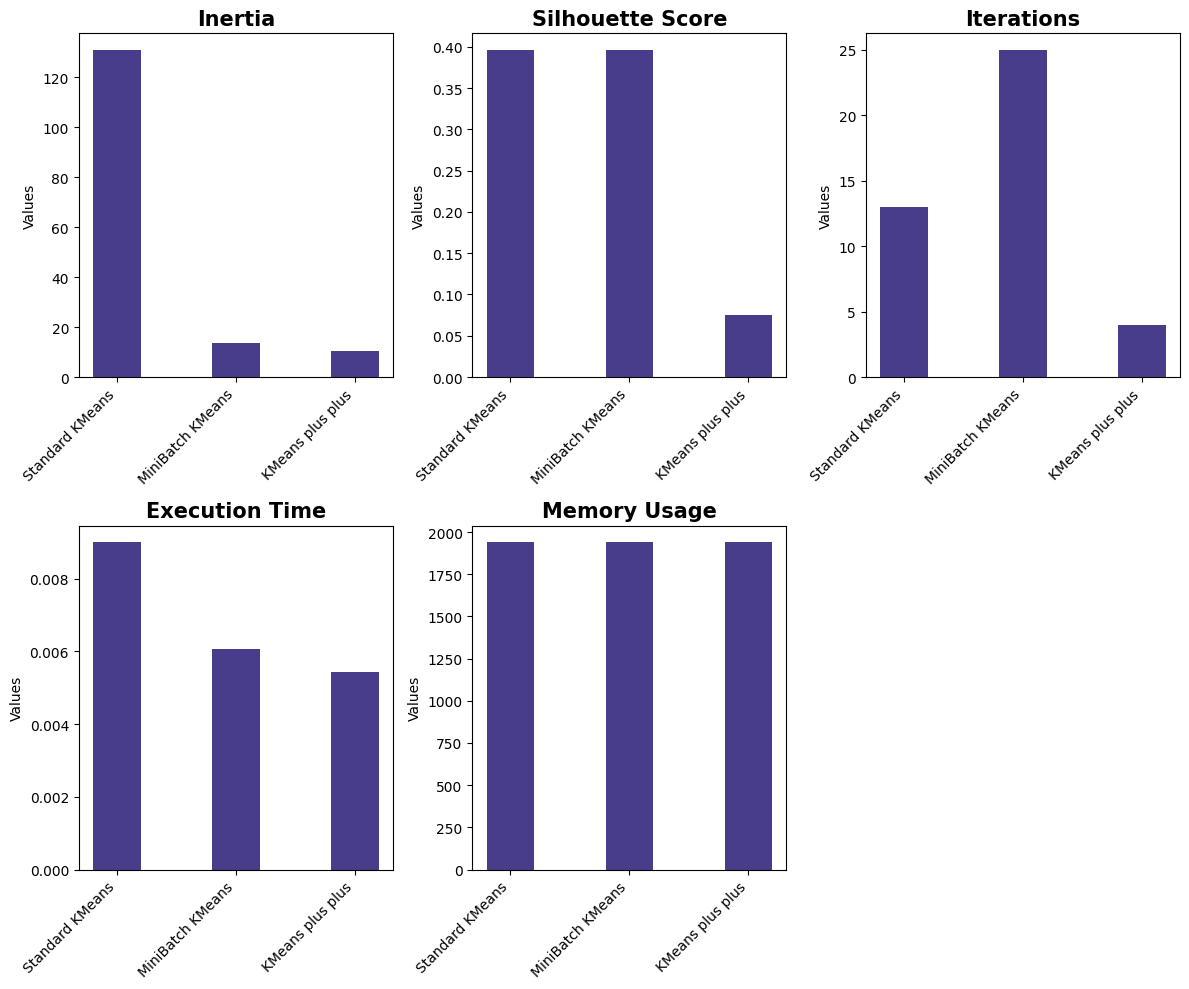

In [4989]:
fig,ax=plt.subplots(2,3,figsize=(12,10))
metrics = MB_VS_KP_VS_SK["Metric"]
for i,ax in enumerate(ax.flatten()):
    if i < len(metrics):
      metric= metrics[i]
      values= MB_VS_KP_VS_SK.loc[MB_VS_KP_VS_SK["Metric"] == metric].iloc[0, 1:]
      labels= ["Standard KMeans", "MiniBatch KMeans","KMeans plus plus"]
      ax.bar(labels,values,width=.4,color='#483D8B')
      ax.set_title(metric, fontsize=15, fontweight="bold")
      ax.set_ylabel("Values")
      ax.tick_params(axis="y")
      ax.set_xticks([0, 1, 2])
      ax.set_xticklabels(labels, rotation=45, ha="right")
    else :
      ax.axis("off")
plt.tight_layout()
plt.show()

In [4990]:
mini_tsne=MiniBatchKMeans(n_clusters=2,random_state=42,init="random")
mini_tsne.fit(X_train_tsne)
train_clusters_tsne=mini_tsne.predict(X_train_tsne)

In [4991]:
inertia_mini_tsne=mini_tsne.inertia_
silhouette_mini_tsne=silhouette_score(X_train_tsne,train_clusters_tsne,random_state=42)
print("Inertia Value: ",inertia_mini_tsne)
print("Silhouette Score:",silhouette_mini_tsne)

Inertia Value:  4210.76611328125
Silhouette Score: 0.8183673


The model achieves a very good separation between clusters, as shown by the high Silhouette Score. This suggests that t-SNE helped to reveal a meaningful low-dimensional structure in the data that clustering could exploit.

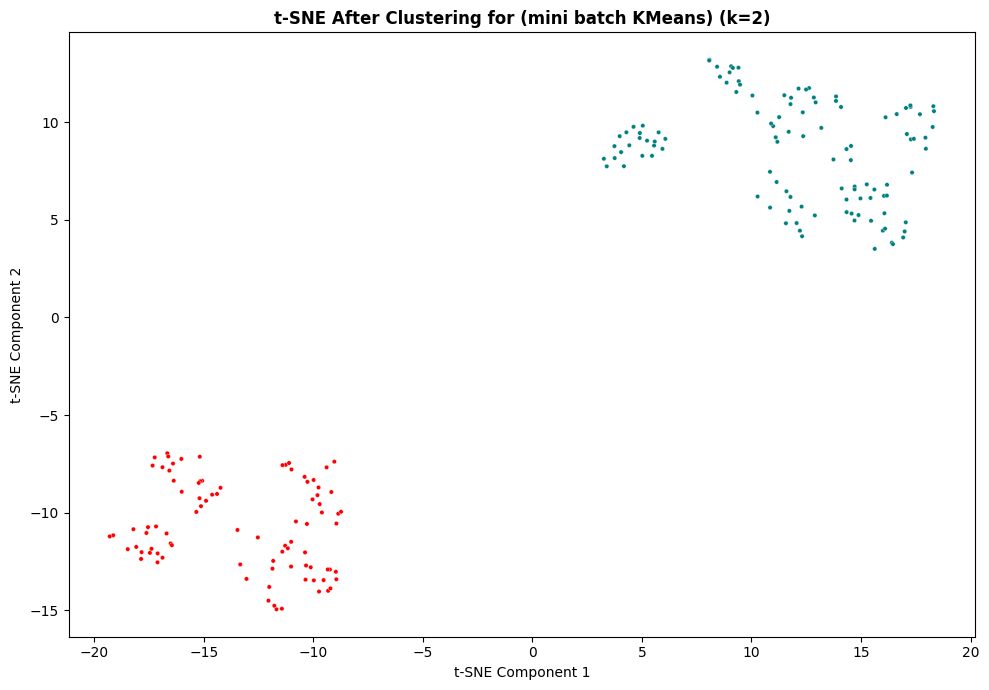

In [4992]:
plt.figure(figsize=(10,7))
label=train_clusters_tsne
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=label, palette=['red','#008080'], s=10, legend=None)
plt.title(f"t-SNE After Clustering for (mini batch KMeans) (k={2})",  fontweight="bold")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

In [4993]:
mini_full=MiniBatchKMeans(n_clusters=best_k_mini,random_state=42,init="random")
mini_full.fit(X_scaled)
train_clusters_full=mini_full.predict(X_scaled)

In [4994]:
inertia_scaled = mini_full.inertia_
silhouette_scaled = silhouette_score(X_scaled, train_clusters_full, random_state=42)
print("Inertia Value: ",inertia_scaled)
print("Silhouette Score:",silhouette_scaled)

Inertia Value:  193.98890785734363
Silhouette Score: 0.34157121761127335


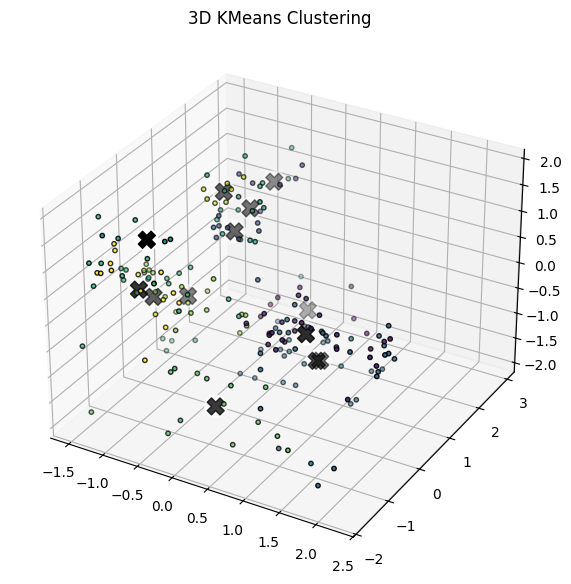

In [4995]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=mini_full.labels_, cmap='viridis', s=10, edgecolor='k')

ax.scatter(mini_full.cluster_centers_[:, 0], mini_full.cluster_centers_[:, 1], mini_full.cluster_centers_[:, 2],
           c='white', marker='o', s=250)
ax.scatter(mini_full.cluster_centers_[:, 0], mini_full.cluster_centers_[:, 1], mini_full.cluster_centers_[:, 2],
           c='black', marker='X', s=150)
ax.set_title("3D KMeans Clustering")
ax.grid(True)

plt.show()

**Compare clustering in full space vs. reduced 2D space:**

In [4996]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [4997]:
min_batch=MiniBatchKMeans(n_clusters=best_k_mini,random_state=42,init="random")
clusterspca= min_batch.fit_predict(X_pca)

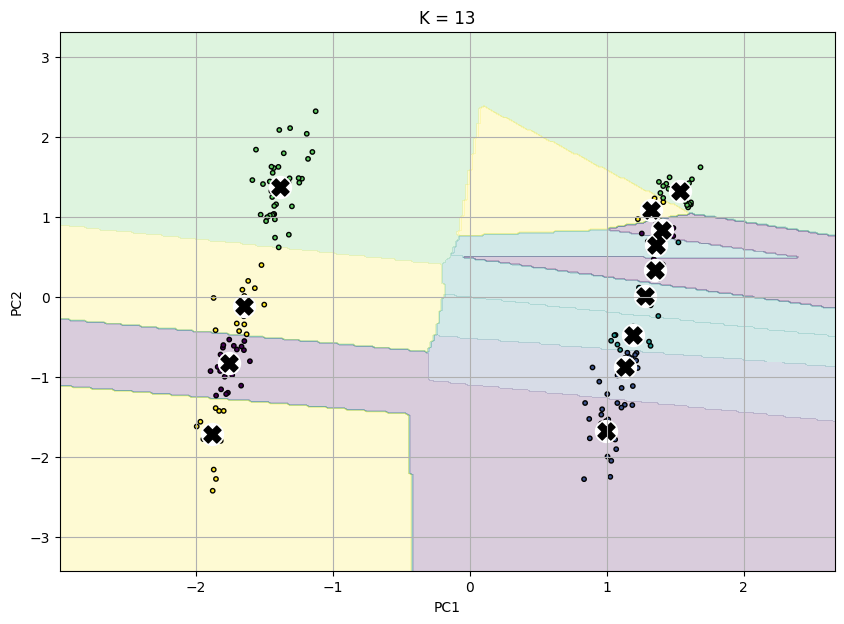

In [4998]:
h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.get_cmap('viridis', 5)

grid = np.zeros((xx.ravel().shape[0], X_pca.shape[1]))
grid[:, 0] = xx.ravel()
grid[:, 1] = yy.ravel()

Z = min_batch.predict(grid).reshape(xx.shape)
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=min_batch.labels_, cmap=cmap, s=10, edgecolor='k')
ax.scatter(min_batch.cluster_centers_[:, 0], min_batch.cluster_centers_[:, 1], c='white', marker='o', s=250)
ax.scatter(min_batch.cluster_centers_[:, 0], min_batch.cluster_centers_[:, 1], c='black', marker='X', s=150)
ax.set_title(f"K = {best_k_mini}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid()
plt.show()

In [4999]:
print("Inertia Value: ",min_batch.inertia_)
print("Silhouette Score:",silhouette_score(X_pca,clusterspca,random_state=42))

Inertia Value:  13.741770744338012
Silhouette Score: 0.5055476984437963


# **DBSCAN**

In [5000]:
dbscan_1=DBSCAN()
y_pred=dbscan_1.fit_predict(X_train_pca)
y_pred

array([-1, -1, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1,  0, -1,  1, -1,
        1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1,  2,  3,  3,  3,  2,
       -1,  3,  4,  2,  4,  2,  4,  3,  4,  4, -1, -1,  2,  4, -1,  2, -1,
       -1,  3,  4,  2, -1,  2,  4,  5,  2, -1,  3,  2,  4, -1,  4,  2,  3,
        4,  2,  3, -1,  2, -1,  5,  4, -1,  3,  5,  2,  3,  4,  5,  3,  2,
        6,  5,  4,  3, -1,  4,  6,  6,  6,  3, -1,  5,  3,  3, -1,  2,  2,
        2,  5, -1, -1,  8, -1,  7, -1,  8, -1, -1, -1, -1,  3,  7, -1,  7,
       -1, -1, -1,  7, -1,  8, -1,  7, -1, -1, -1,  7, -1,  8, -1,  8, -1,
        7, -1,  7, -1,  7, -1,  7, -1,  7, -1,  7, -1,  7, -1,  7, -1, -1,
       -1, -1, -1,  8, -1,  7, -1, -1, -1, -1, -1,  7, -1,  7, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [5001]:
noise_points=X_train_pca[dbscan_1.labels_==-1]
print("Number of Noise Points: ",len(noise_points))
cluster_points=X_train_pca[dbscan_1.labels_!=-1]
print("Number of Cluster Points: ",len(cluster_points))
print("Number of Clusters: ",len(set(dbscan_1.labels_)))
print("percentage of noise points =",(len(noise_points)/len(X_train_pca))*100)

Number of Noise Points:  105
Number of Cluster Points:  95
Number of Clusters:  10
percentage of noise points = 52.5


In [5002]:
# noise_points=X_train_pca[y_pred==-1]
# print("Number of Noise Points: ",len(noise_points))
# cluster_points=X_train_pca[y_pred!=-1]
# print("Number of Cluster Points: ",len(cluster_points))
# print("Number of Cluster ",len(set(y_pred)))
# print("percentage of noise points =",(len(noise_points)/len(X_train_pca))*100)

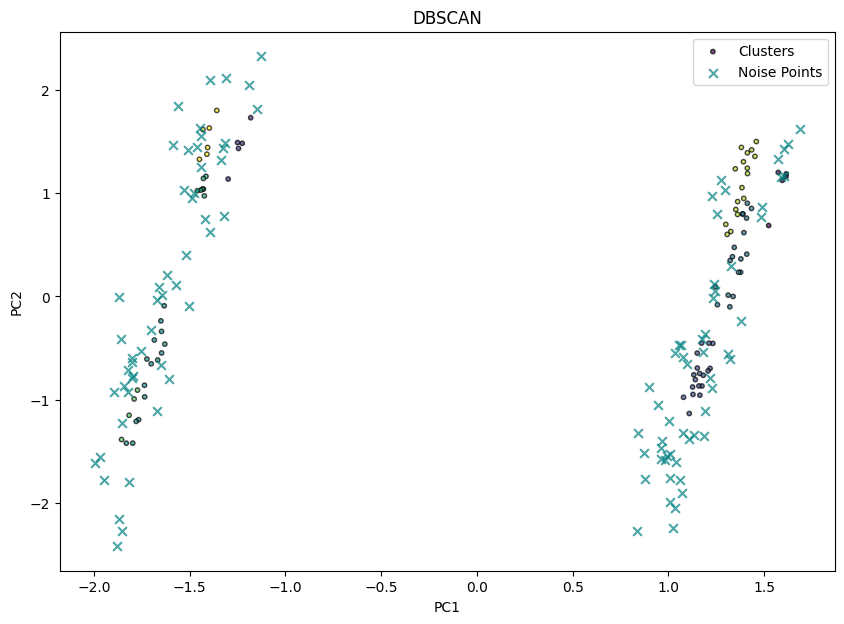

In [5003]:
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],c=y_pred[y_pred!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],marker='x',c='#008080',s=40,alpha=0.7,label='Noise Points')
plt.title("DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

We applied DBSCAN using the default hyperparameters values , but the result showed that more than 50% of the data points considered outliers . This happened because the default parameter settings were not well-suited for our dataset so now we need to apply the hyperparameter tuning

**Tune eps and min_samples**

**eps** : The maximum distance between two samples to be considered neighbors(radius)

**min_samples**: The number of points required to form a dense region (a core point)


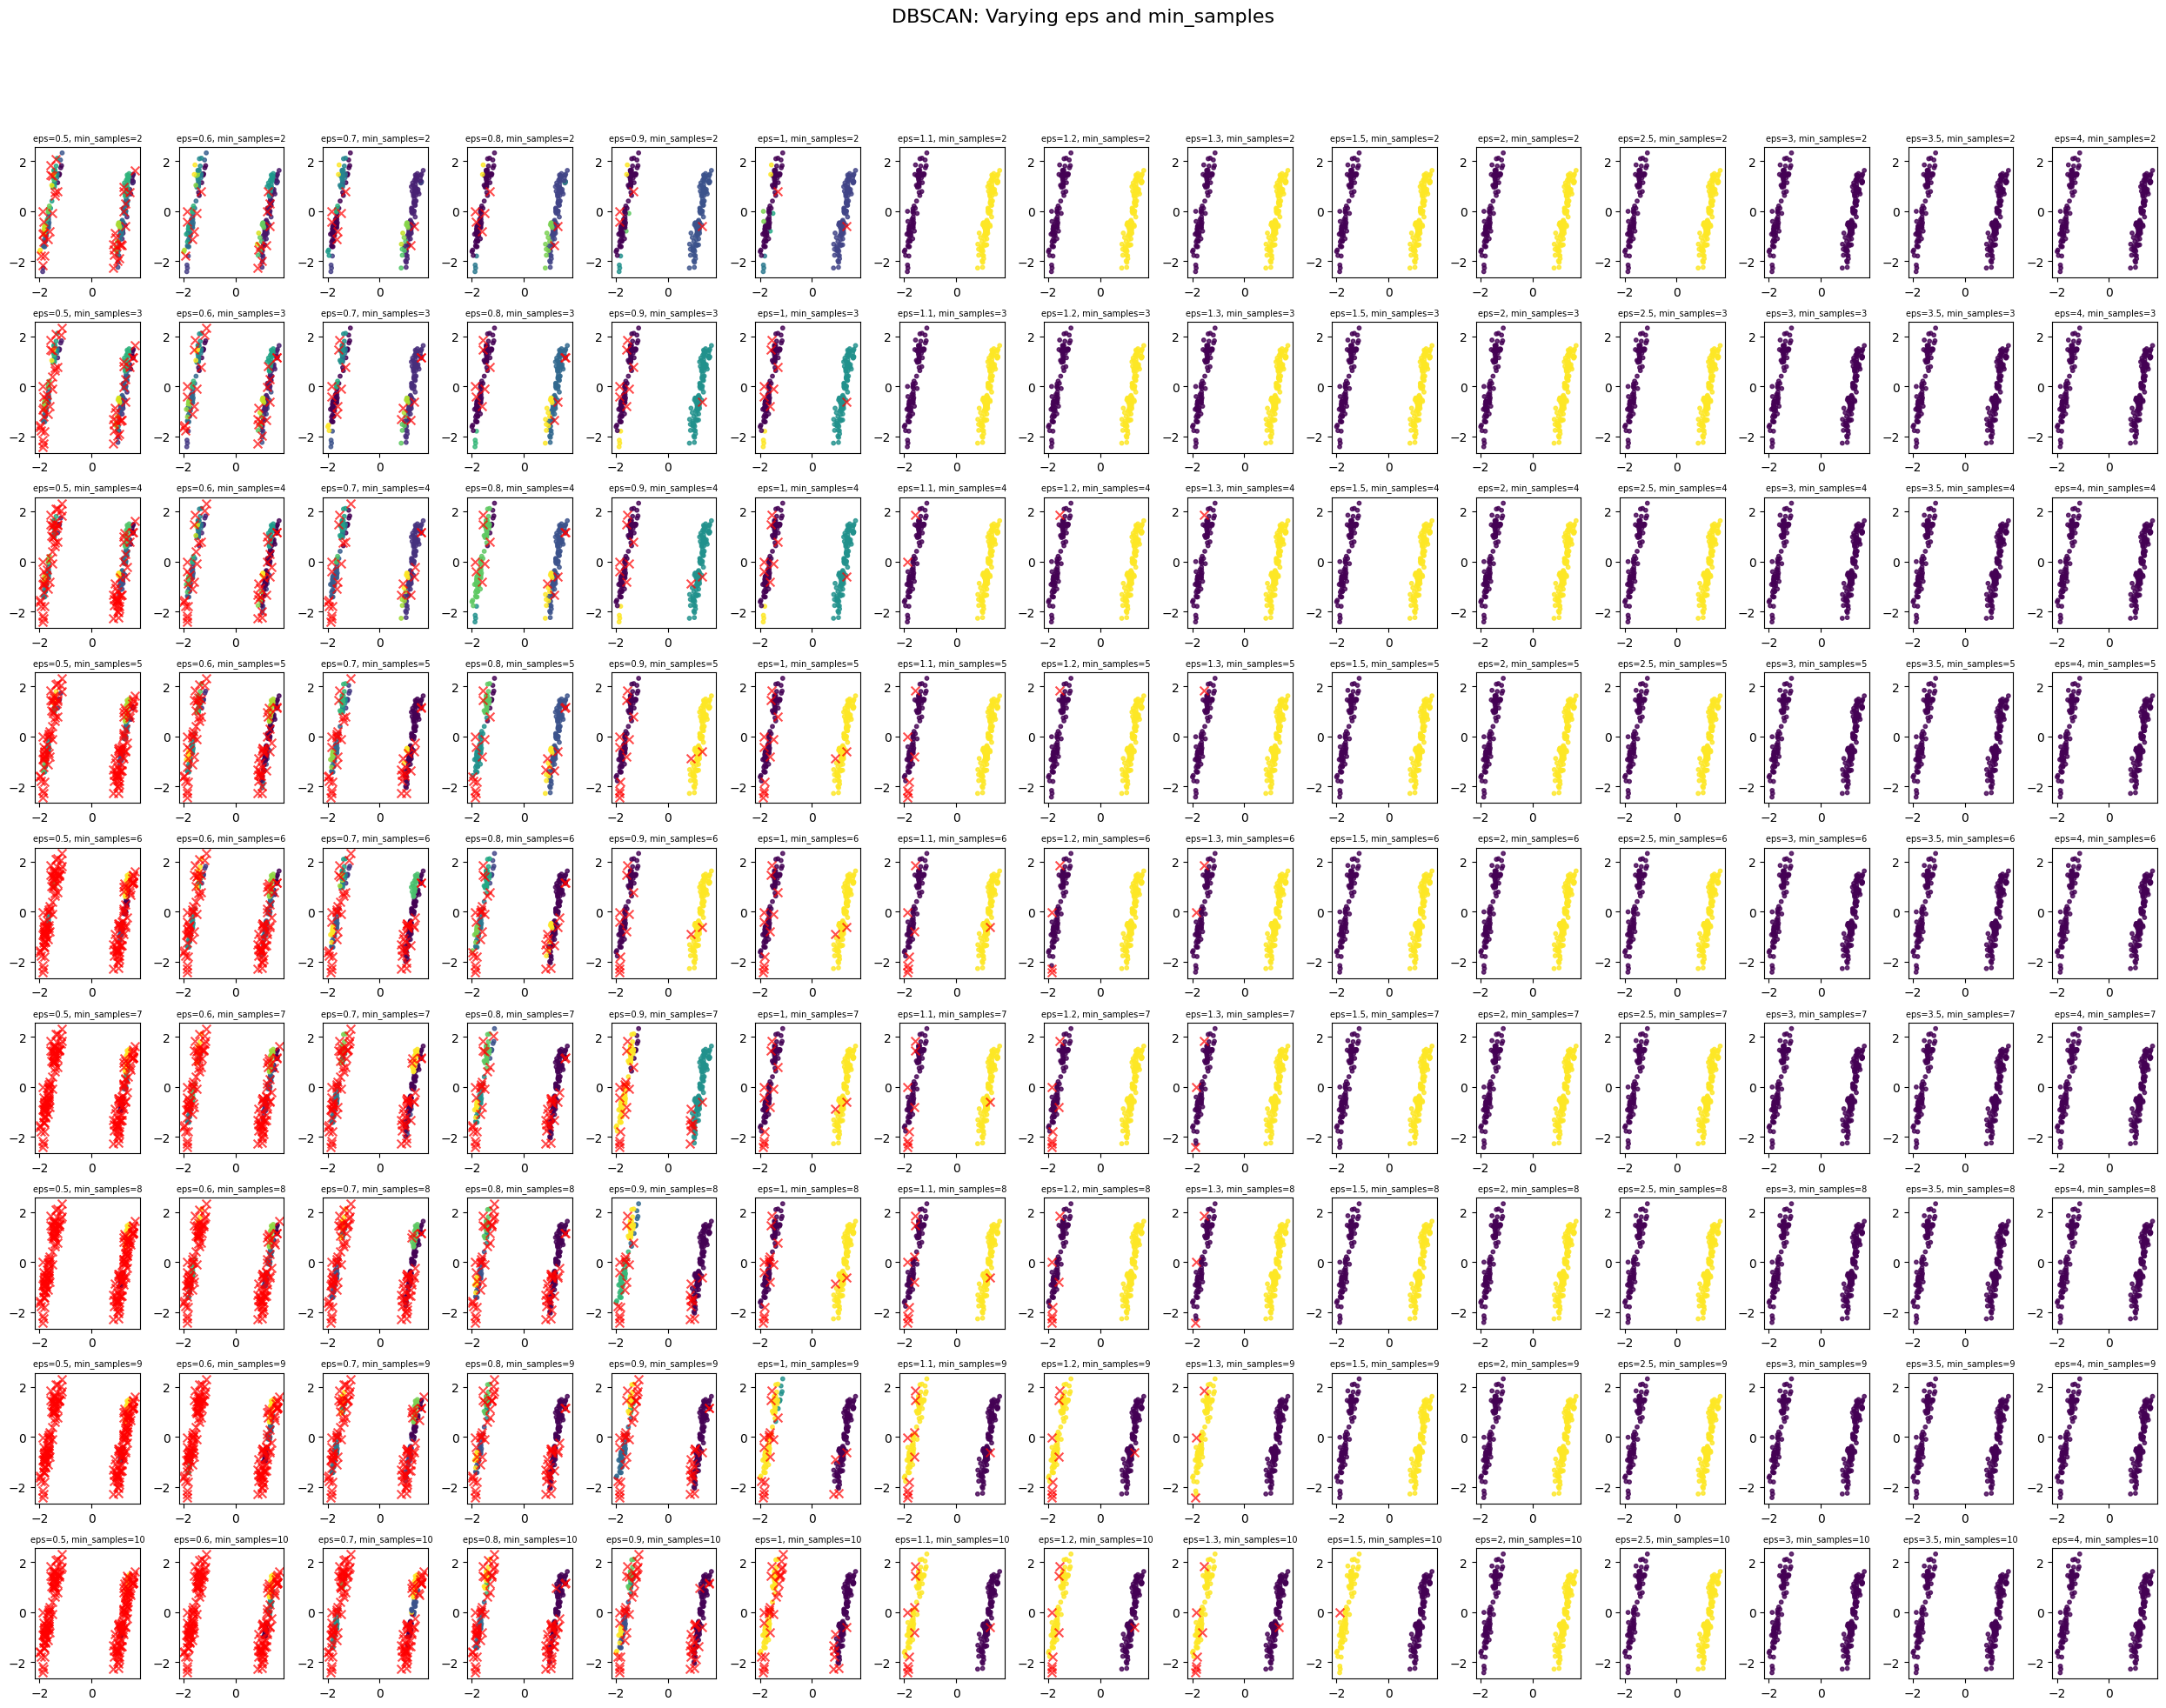

In [5004]:
scores={}
noise_percent={}
eps_values = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.5,2,2.5,3,3.5,4]
min_samples_values = [2,3,4,5,6,7,8,9,10]

fig, axs = plt.subplots(len(min_samples_values), len(eps_values), figsize=(25, 20))
fig.suptitle("DBSCAN: Varying eps and min_samples", fontsize=16)

for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        ax = axs[i, j]
        db = DBSCAN(eps=eps, min_samples=min_samples)
        y = db.fit_predict(X_train_pca)

        noise = y == -1
        clusters = y != -1
        n_clusters = len(set(y)) - (1 if -1 in y else 0)
        if n_clusters >= 2:
         score= silhouette_score(X_train_pca,y)
         scores[(eps,min_samples)]=score
        else:

         scores[(eps, min_samples)] = -1

        n_noise=list(y).count(-1)
        n_clusters= len(set(y))-(1 if -1 in y else 0)
        noise_percent[(eps,min_samples)]=(n_noise / len(y))


        ax.scatter(X_train_pca[clusters, 0], X_train_pca[clusters, 1], c=y[clusters], s=10,alpha=0.8)
        ax.scatter(X_train_pca[noise, 0], X_train_pca[noise, 1], c='red', marker='x', s=50,alpha=0.7)
        ax.set_title(f"eps={eps}, min_samples={min_samples}", fontsize = 7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [5005]:
best_param=max(scores, key=scores.get)
best_score=scores[best_param]
ns=min(noise_percent,key=noise_percent.get)
print(f"Best parameters: eps={best_param[0]}, min_samples={best_param[1]}")
print(f"Best Silhouette Score: {best_score}")
print(f"Noise Percentage: {noise_percent[ns]}")
print(ns[0])
print(ns[1])

Best parameters: eps=1.1, min_samples=2
Best Silhouette Score: 0.39644160577705434
Noise Percentage: 0.0
1.1
2


In [5006]:
target_min=0.001
target_max=0.05

for params, percent in noise_percent.items():
    if target_min <= percent <= target_max:
        eps, min_samples = params
        score = scores.get(params, -1)
        print(f"eps={eps}, min_samples={min_samples} -> Noise={percent:.4f}%, Silhouette={score:.4f}")

eps=0.7, min_samples=2 -> Noise=0.0400%, Silhouette=0.0935
eps=0.8, min_samples=2 -> Noise=0.0350%, Silhouette=0.1233
eps=0.9, min_samples=2 -> Noise=0.0200%, Silhouette=0.2088
eps=1, min_samples=2 -> Noise=0.0100%, Silhouette=0.1737
eps=0.9, min_samples=3 -> Noise=0.0400%, Silhouette=0.2925
eps=1, min_samples=3 -> Noise=0.0400%, Silhouette=0.2925
eps=0.9, min_samples=4 -> Noise=0.0450%, Silhouette=0.2956
eps=1, min_samples=4 -> Noise=0.0400%, Silhouette=0.2925
eps=1.1, min_samples=4 -> Noise=0.0100%, Silhouette=0.3531
eps=1.2, min_samples=4 -> Noise=0.0050%, Silhouette=0.3413
eps=1.3, min_samples=4 -> Noise=0.0050%, Silhouette=0.3413
eps=1.1, min_samples=5 -> Noise=0.0350%, Silhouette=0.3438
eps=1.2, min_samples=5 -> Noise=0.0050%, Silhouette=0.3413
eps=1.3, min_samples=5 -> Noise=0.0050%, Silhouette=0.3413
eps=1.1, min_samples=6 -> Noise=0.0400%, Silhouette=0.3516
eps=1.2, min_samples=6 -> Noise=0.0200%, Silhouette=0.3593
eps=1.3, min_samples=6 -> Noise=0.0100%, Silhouette=0.3531
eps

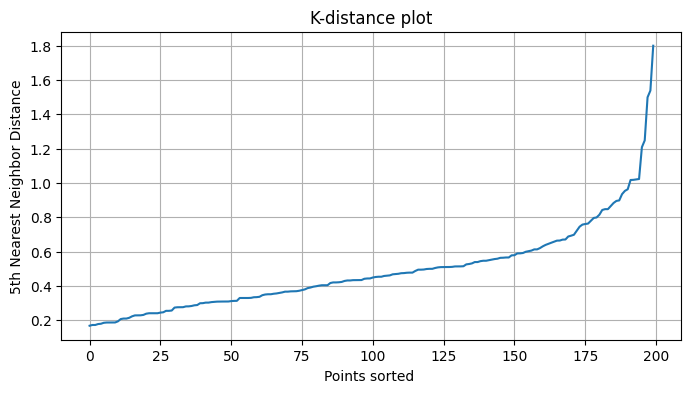

In [5007]:
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X_train_pca)
distances, indices = neighbors_fit.kneighbors(X_train_pca)
distances = np.sort(distances[:, 2])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-distance plot")
plt.xlabel("Points sorted ")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid()
plt.show()

In [5008]:
knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
eps_value = distances[knee.knee]
eps_value

1.0233421909369342

 Eps selected using the knee method

In [5009]:
dbscan_1=DBSCAN(eps=1.0233,min_samples=3)
y_pred=dbscan_1.fit_predict(X_train_pca)
noise_points=X_train_pca[dbscan_1.labels_==-1]
print("Number of Noise Points: ",len(noise_points))
cluster_points=X_train_pca[dbscan_1.labels_!=-1]
print("Number of Cluster Points: ",len(X_train_pca))
print("Number of Clusters: ",len(set(dbscan_1.labels_)))
print("percentage of noise points =",(len(noise_points)/len(X_train_pca))*100)
ch_score = calinski_harabasz_score(X_train_pca, y_pred)
print("Calinski-Harabasz Index:", ch_score)
db_score = davies_bouldin_score(X_train_pca, y_pred)
print("Davies-Bouldin Index:", db_score)

Number of Noise Points:  4
Number of Cluster Points:  200
Number of Clusters:  4
percentage of noise points = 2.0
Calinski-Harabasz Index: 49.14307797427248
Davies-Bouldin Index: 2.3889658453769793


We evaluated clustering quality based on the noise ratio produced by DBSCAN

In [5010]:
dbscan_2=DBSCAN(eps=1.04,min_samples=2)
y_pred=dbscan_2.fit_predict(X_train_pca)
noise_points=X_train_pca[dbscan_2.labels_==-1]
print("Number of Noise Points: ",len(noise_points))
cluster_points=X_train_pca[dbscan_2.labels_!=-1]
print("Number of Cluster Points: ",len(cluster_points))
print("Number of Clusters: ",len(set(dbscan_2.labels_)))
print("percentage of noise points =",(len(noise_points)/len(X_train_pca))*100)
ch_score = calinski_harabasz_score(X_train_pca, y_pred)
print("Calinski-Harabasz Index:", ch_score)
db_score = davies_bouldin_score(X_train_pca, y_pred)
print("Davies-Bouldin Index:", db_score)

Number of Noise Points:  2
Number of Cluster Points:  198
Number of Clusters:  4
percentage of noise points = 1.0
Calinski-Harabasz Index: 51.30824861580897
Davies-Bouldin Index: 1.0279491719650486


In [5011]:
dbscan_1=DBSCAN(eps=1.4,min_samples=2)
y_pred=dbscan_1.fit_predict(X_train_pca)
noise_points=X_train_pca[dbscan_1.labels_==-1]
print("Number of Noise Points: ",len(noise_points))
cluster_points=X_train_pca[dbscan_1.labels_!=-1]
print("Number of Cluster Points: ",len(cluster_points))
print("Number of Clusters: ",len(set(dbscan_1.labels_)))
print("percentage of noise points =",(len(noise_points)/len(X_train_pca))*100)
ch_score = calinski_harabasz_score(X_train_pca, y_pred)
print("Calinski-Harabasz Index:", ch_score)
db_score = davies_bouldin_score(X_train_pca, y_pred)
print("Davies-Bouldin Index:", db_score)

Number of Noise Points:  0
Number of Cluster Points:  200
Number of Clusters:  2
percentage of noise points = 0.0
Calinski-Harabasz Index: 133.1328641424857
Davies-Bouldin Index: 1.1425452037621548


Optimal number of clusters based on silhouette value

In [5012]:
dbscan_1=DBSCAN(eps=1.1,min_samples=2)
y_pred=dbscan_1.fit_predict(X_train_pca)
noise_points=X_train_pca[dbscan_1.labels_==-1]
print("Number of Noise Points: ",len(noise_points))
cluster_points=X_train_pca[dbscan_1.labels_!=-1]
print("Number of Cluster Points: ",len(cluster_points))
print("Number of Clusters: ",len(set(dbscan_1.labels_)))
print("percentage of noise points =",(len(noise_points)/len(X_train_pca))*100)
ch_score = calinski_harabasz_score(X_train_pca, y_pred)
print("Calinski-Harabasz Index:", ch_score)
db_score = davies_bouldin_score(X_train_pca, y_pred)
print("Davies-Bouldin Index:", db_score)

Number of Noise Points:  0
Number of Cluster Points:  200
Number of Clusters:  2
percentage of noise points = 0.0
Calinski-Harabasz Index: 133.1328641424857
Davies-Bouldin Index: 1.1425452037621548


Although the configuration with the highest Silhouette Score showed numerically optimal separation, visual inspection revealed that the resulting clusters were not realistic or interpretable. This highlights a common limitation of relying solely on clustering metrics, as high scores can sometimes favor artificial separation or unbalanced groupings. Hence, our final model selection also incorporated visual assessment and domain relevance to ensure meaningful segmentation.



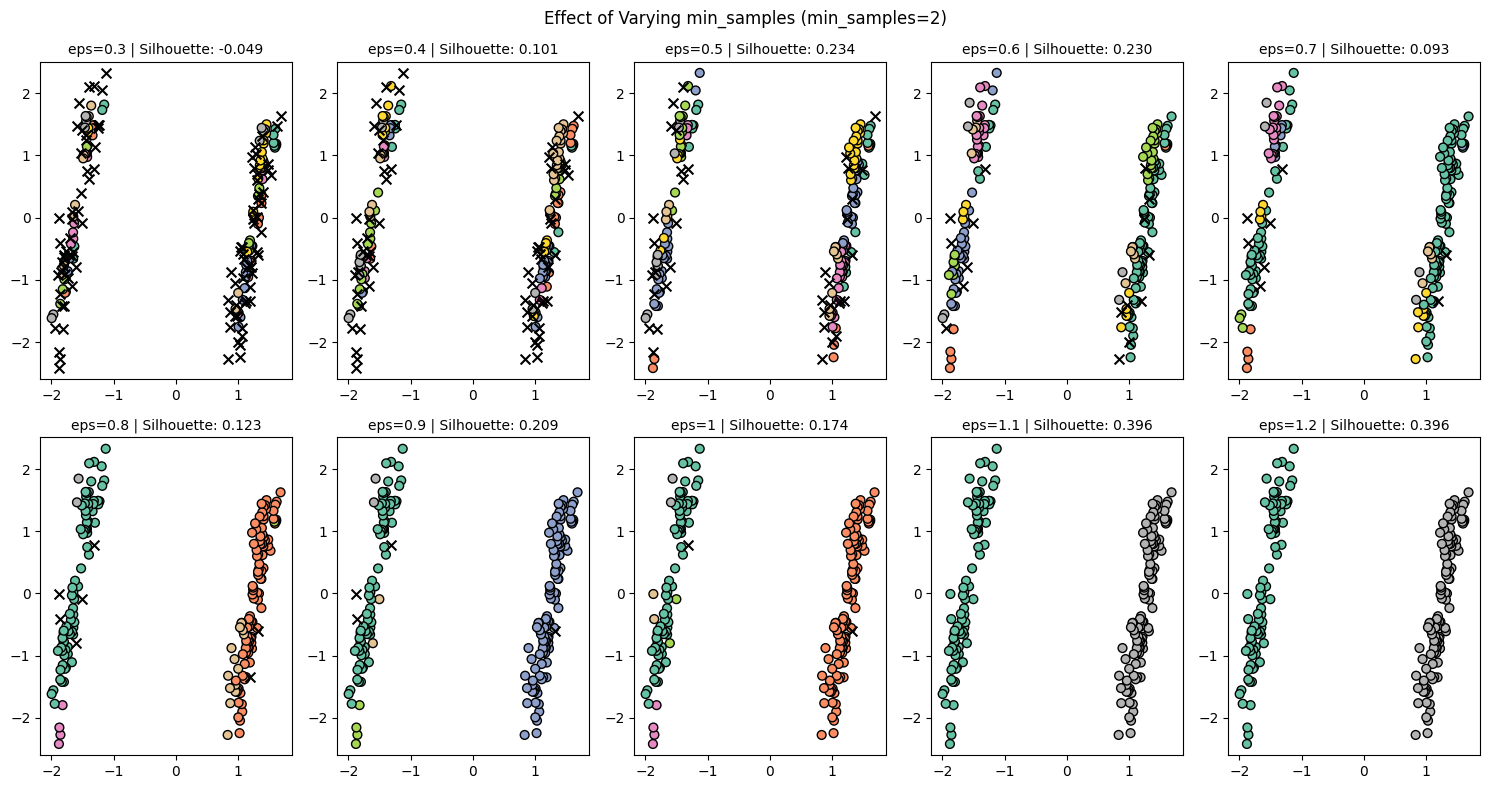

In [5013]:
eps_values_1 = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2]
silhouette_scores = []
plt.figure(figsize=(15, 8))
for i, eps in enumerate(eps_values_1):
    y = DBSCAN(eps=eps, min_samples=2).fit_predict(X_train_pca)
    noise = y == -1
    clusters = y != -1
    if len(set(y)) > 1:
        score = silhouette_score(X_train_pca, y)
    else:
        score = -1

    plt.subplot(2, 5, i + 1)
    plt.scatter(X_train_pca[clusters, 0], X_train_pca[clusters, 1], c=y[clusters], cmap='Set2', s=40, edgecolor='k')
    plt.scatter(X_train_pca[noise, 0], X_train_pca[noise, 1], c='black', marker='x', s=50)
    plt.title(f"eps={eps} | Silhouette: {score:.3f}",fontsize=10)
    plt.axis('equal')

plt.suptitle("Effect of Varying min_samples (min_samples=2)")
plt.tight_layout()
plt.show()

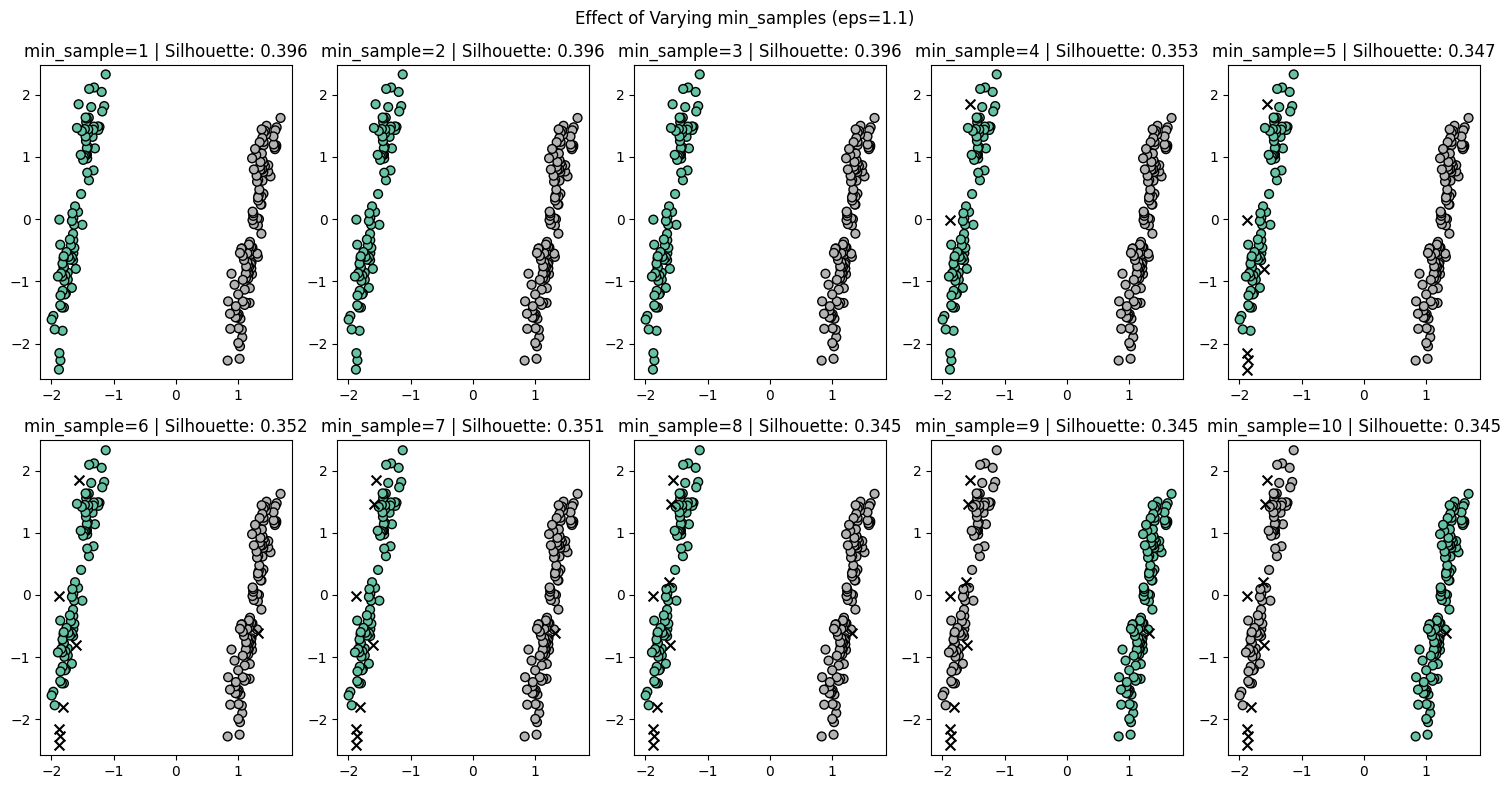

In [5014]:
min_samples_values = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(15, 8))
for i, ms in enumerate(min_samples_values):
    y = DBSCAN(eps=1.11, min_samples=ms).fit_predict(X_train_pca)
    noise = y == -1
    clusters = y != -1
    if len(set(y)) > 1:
        score = silhouette_score(X_train_pca, y)
    else:
        score = -1

    plt.subplot(2, 5, i + 1)
    plt.scatter(X_train_pca[clusters, 0], X_train_pca[clusters, 1], c=y[clusters], cmap='Set2', s=40, edgecolor='k')
    plt.scatter(X_train_pca[noise, 0], X_train_pca[noise, 1], c='black', marker='x', s=50)
    plt.title(f"min_sample={ms} | Silhouette: {score:.3f}")
    plt.axis('equal')

plt.suptitle("Effect of Varying min_samples (eps=1.1)")
plt.tight_layout()
plt.show()

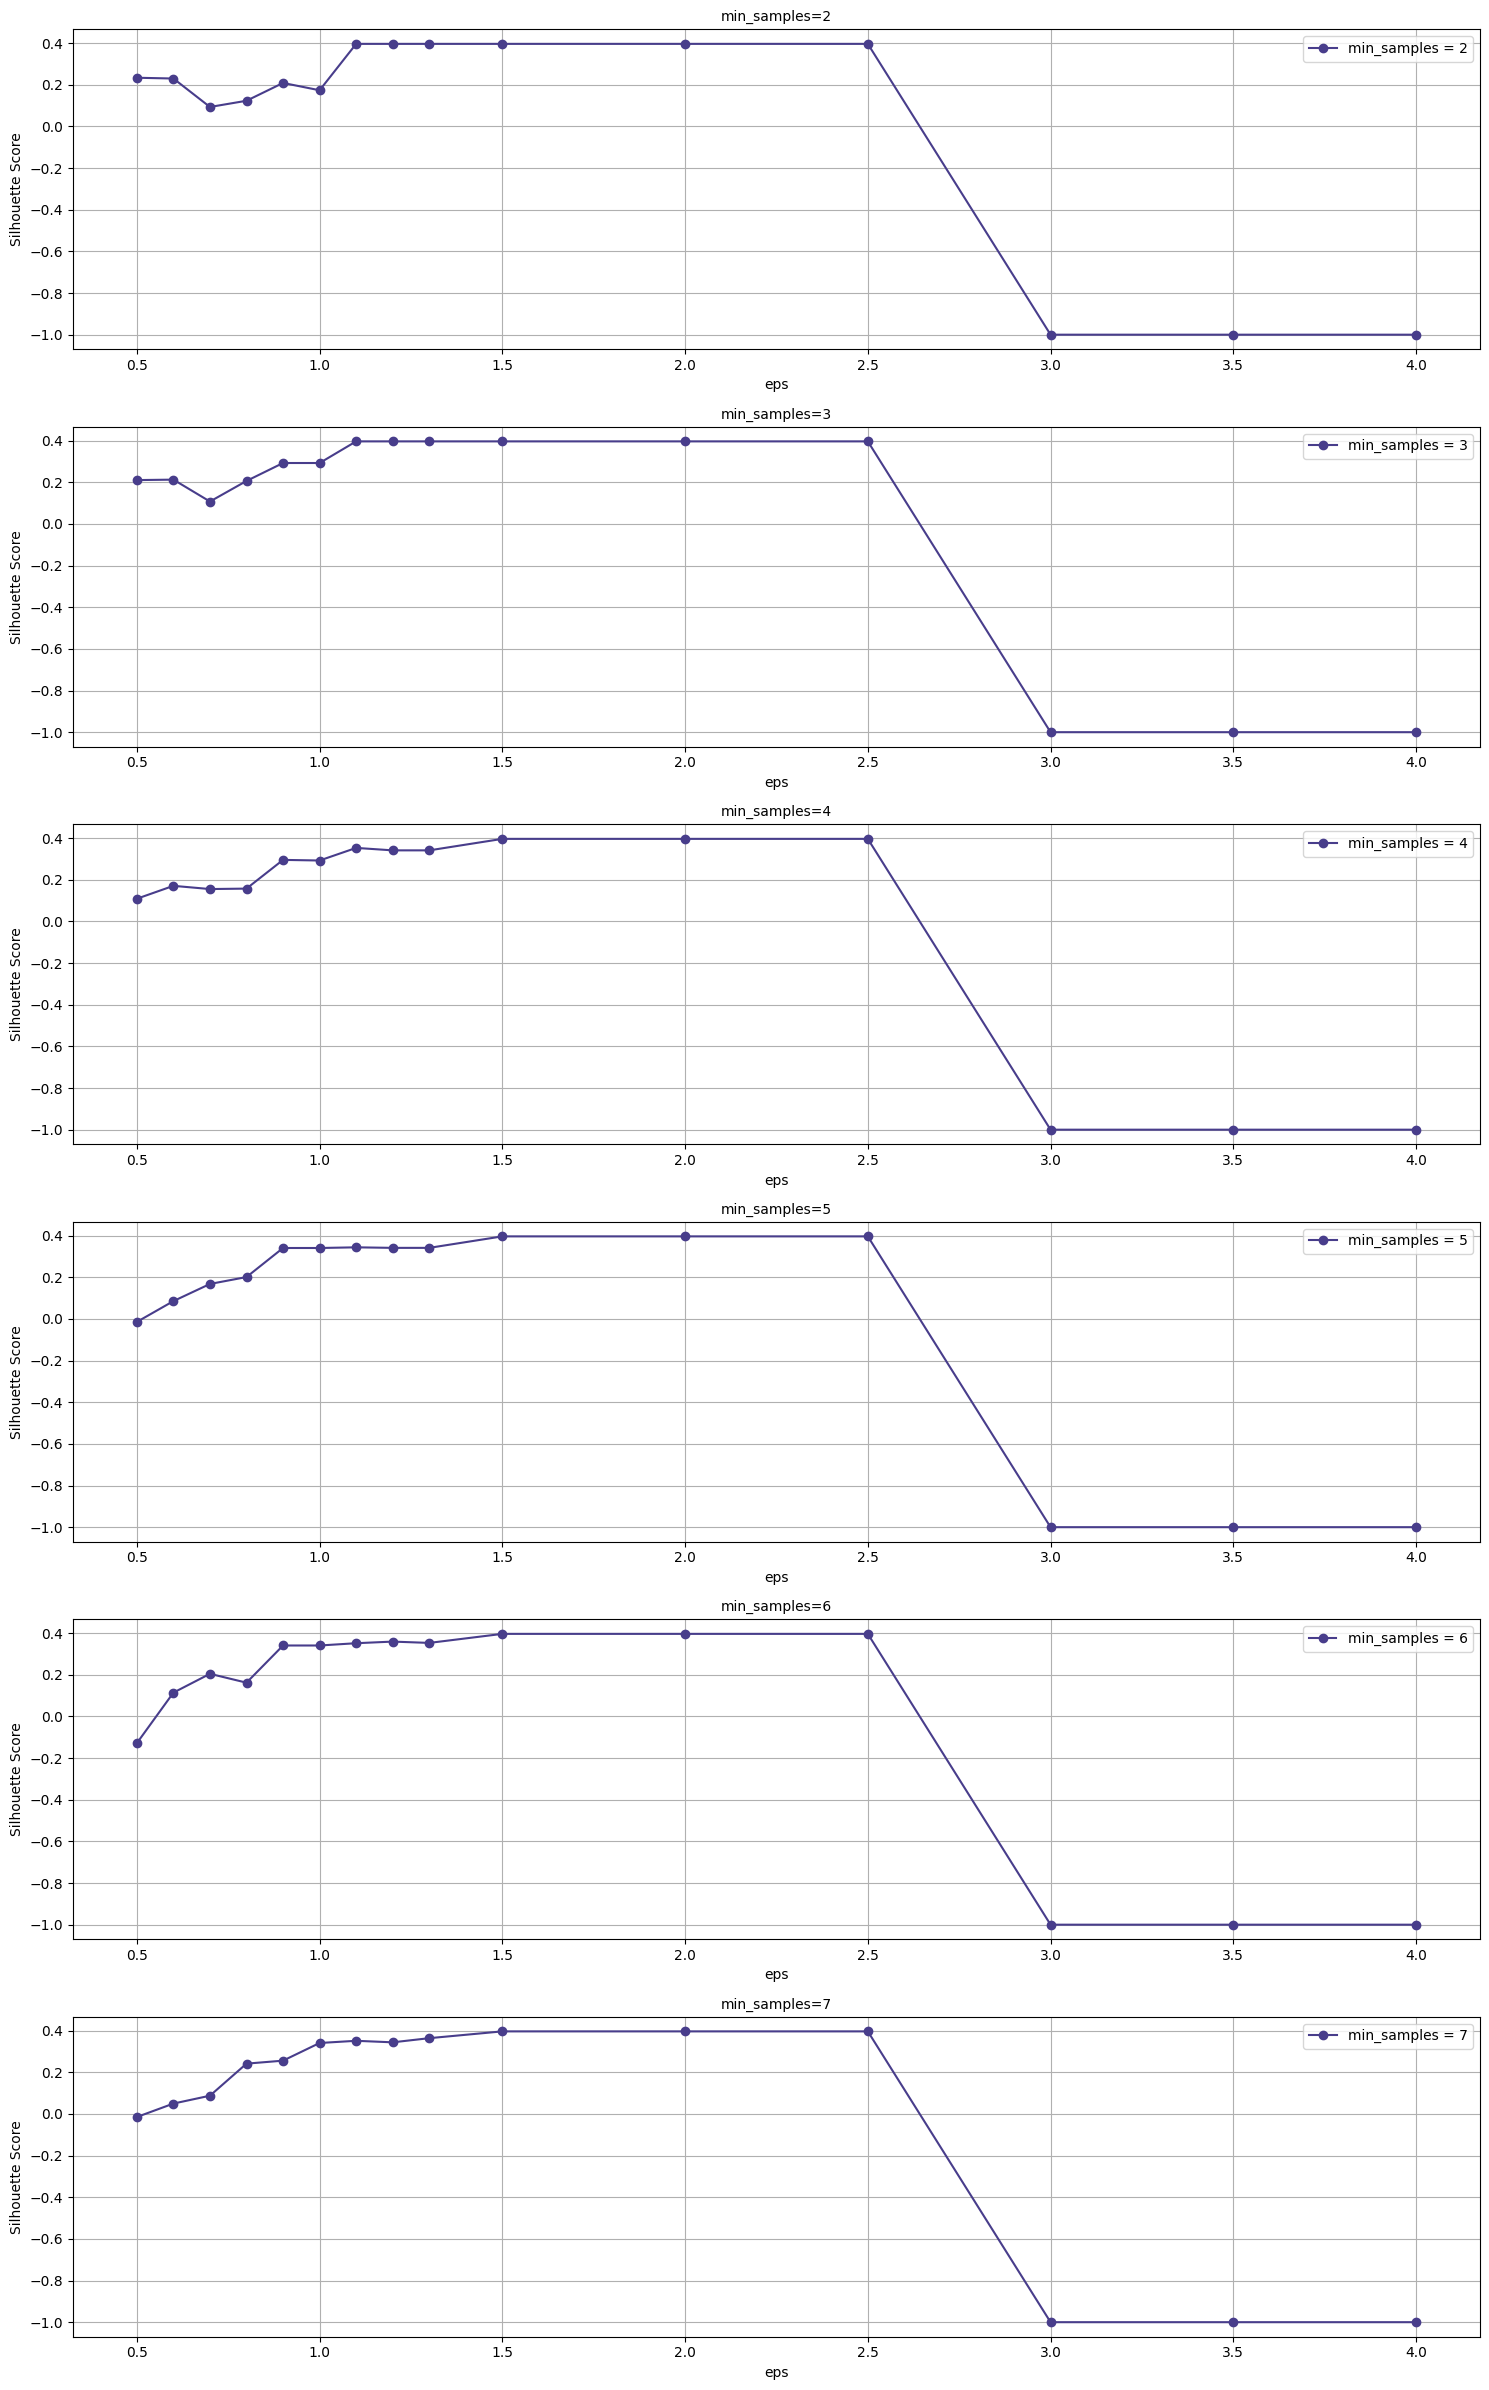

In [5015]:
eps_values = [0.4,0.5,0.6,0.7,0.8,0.9]
min_samples_values = [2,3,4,5,6,7]


plt.figure(figsize=(15,4*len(min_samples_values)))
for i , min_samples in enumerate(min_samples_values, 1):
  eps_values=sorted(k[0] for k in scores.keys() if k[1]==min_samples)
  scores_for_min_samples = [scores[(eps, min_samples)] for eps in eps_values]
  plt.subplot(len(min_samples_values),1,i)
  plt.plot(eps_values,scores_for_min_samples,marker='o',color='#483D8B',label=f'min_samples = {min_samples}')
  plt.grid()
  plt.xlabel("eps")
  plt.ylabel("Silhouette Score")
  plt.legend()
  plt.title(f"min_samples={min_samples}",fontsize=10)
plt.tight_layout()
plt.show()

In [5016]:
best_param = max(scores, key=scores.get)
best_score=scores[best_param]
print("Best Parameters:", best_param)
print("Best Score:", best_score)

Best Parameters: (1.1, 2)
Best Score: 0.39644160577705434


we applyed maniual grid search by tisting a range of values for eps and min_samples we used a wide range to cover all poissible cases and the last cell shows the best hyperparameter and the bst silhoutte score

In DBSCAN, noise points are those that do not belong to any cluster — they're considered outliers or anomalies

In [5017]:
dbscan_1=DBSCAN(eps=0.4,min_samples=2)
labels=dbscan_1.fit_predict(X_train_pca)

n_noise=list(labels).count(-1)
n_clusters= len(set(labels))-(1 if -1 in labels else 0)
n_clusterss=X_train_pca[dbscan_1.labels_!=-1]
print("Number of clusters found:", n_clusters)
print("Number of Cluster Points: ",len(n_clusterss))
print("Number of Noise Points: ",n_noise)
print("Percentage of noise points: ",(100 * n_noise / len(labels)))

Number of clusters found: 34
Number of Cluster Points:  135
Number of Noise Points:  65
Percentage of noise points:  32.5


**DBSCAN detected X noise points — and this shows its strength in separating structure from randomness.**

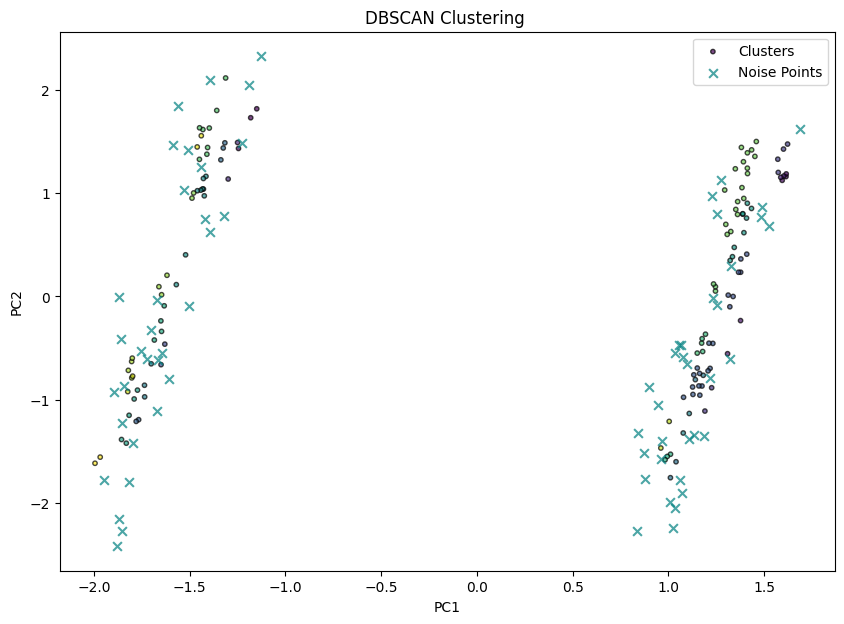

In [5018]:
noise_points = X_train_pca[labels == -1]
cluster_points = X_train_pca[labels != -1]

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)


plt.figure(figsize=(10, 7))

plt.scatter(cluster_points[:,0],cluster_points[:,1],c=labels[labels!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')

plt.scatter(noise_points[:,0],noise_points[:,1],c='#008080',s=40,alpha=0.7,marker='x',label='Noise Points')

plt.title("DBSCAN Clustering ")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

**How the point classify as an noise point:**

if the point does not have enough neighboring points (min_samples)within a given distance (eps), and it is not within the neighborhood of any core point it classified as noise


After tuning the DBSCAN paramerters , the algorithm successfully identified 21 clusters with 11 noise points

In [5019]:
if len(set(labels) - {-1}) > 1:
    score_dbscan_ch= calinski_harabasz_score(X_train_pca, labels)
else:
    score_dbscan_ch= -1

print("Calinski-Harabasz Score - DBSCAN:", score_dbscan_ch)

Calinski-Harabasz Score - DBSCAN: 7.425001221240124


**Calinski-Harabasz Score = "How well your data is grouped."**

In [5020]:
Ndf=pd.DataFrame(noise_points)
print("Noise stats:\n", Ndf.describe())

Noise stats:
                0          1          2          3
count  65.000000  65.000000  65.000000  65.000000
mean   -0.226218  -0.396114   0.125781  -0.211593
std     1.408822   1.265355   1.375257   0.706761
min    -1.946158  -2.419464  -1.913170  -2.176835
25%    -1.667161  -1.379590  -1.107697  -0.624876
50%     0.834285  -0.591515   0.082806  -0.096106
75%     1.078060   0.745266   1.283667   0.180835
max     1.684669   2.325953   2.806928   1.407884


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.490887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.161755
[t-SNE] KL divergence after 500 iterations: 0.102176


<ipython-input-5021-f58cfa4abb57>:6: UserWarning:


The palette list has fewer values (2) than needed (43) and will cycle, which may produce an uninterpretable plot.



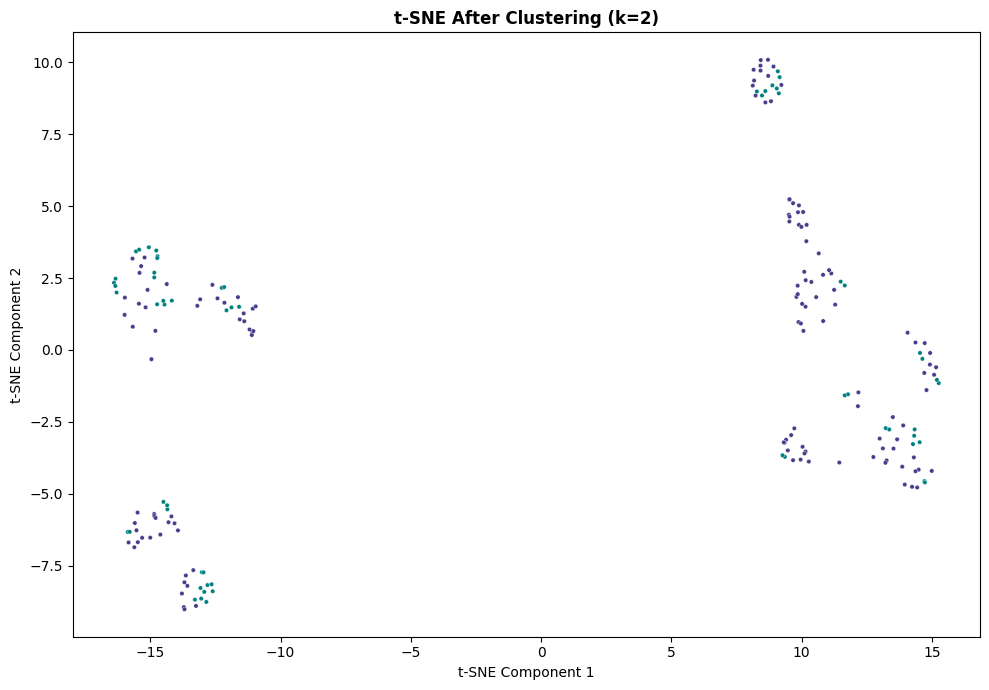

In [5021]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500, verbose=1)
X_train_tsne2 = tsne.fit_transform(X_train_tsne)
db=DBSCAN(eps=0.4, min_samples=2)
y_pred=db.fit_predict(X_train_tsne)
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_train_tsne2[:, 0], y=X_train_tsne2[:, 1], hue=y_pred, palette=['#483D8B','#008080'], s=10, legend=None)
plt.title(f"t-SNE After Clustering (k={2})",  fontweight="bold")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.490887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.161755
[t-SNE] KL divergence after 500 iterations: 0.102176


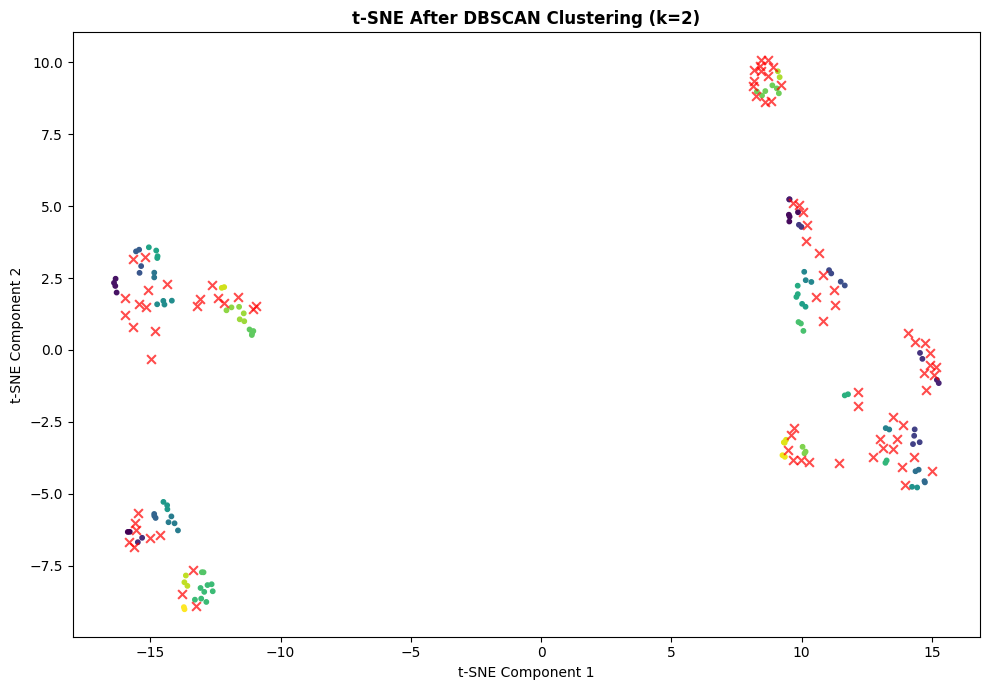

In [5022]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500, verbose=1)
X_train_tsne2 = tsne.fit_transform(X_train_tsne)
db=DBSCAN(eps=0.4, min_samples=2)
y_pred=db.fit_predict(X_train_tsne)
noise_points=X_train_tsne2[y_pred==-1]
cluster_points=X_train_tsne2[y_pred!=-1]
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=y_pred[y_pred!=-1], s=10)
plt.scatter(noise_points[:,0],noise_points[:,1],c='red',s=40,alpha=0.7,marker='x',label='Noise Points')
plt.title(f"t-SNE After DBSCAN Clustering (k={2})",  fontweight="bold")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

**Compare clustering in full space vs. reduced 2D space.**

In [5023]:
dbscan_full=DBSCAN(eps=0.4,min_samples= 2)
y_pred=dbscan_full.fit_predict(X_scaled)
noise_points=X_scaled[y_pred==-1]
cluster_points=X_scaled[y_pred!=-1]
print("Number of Cluster Points: ",len(cluster_points))
print("Number of Clusters ",len(set(y_pred)))
print("Number of Noise Points: ",len(noise_points))

Number of Cluster Points:  135
Number of Clusters  35
Number of Noise Points:  65


Text(0, 0.5, 'Feature 2')

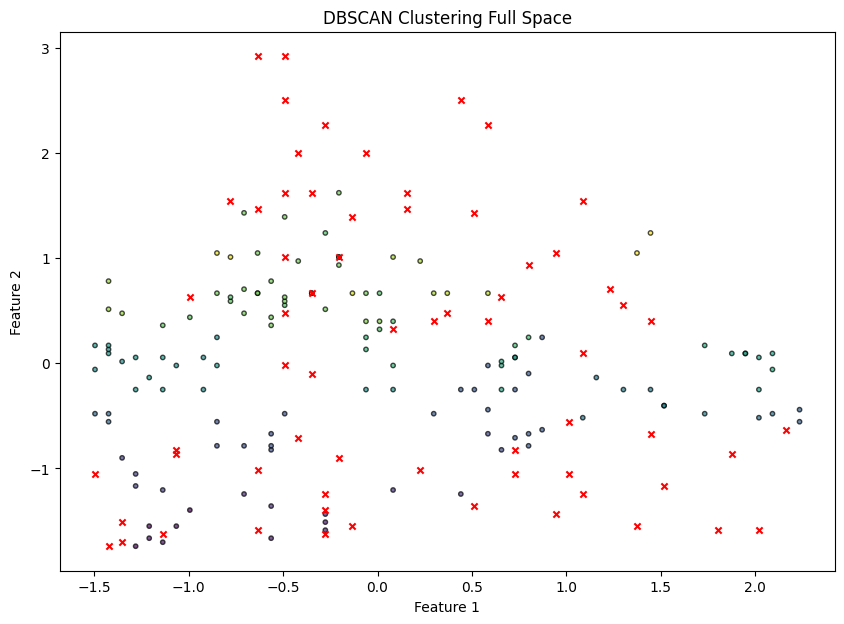

In [5024]:
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],s=10,label='Cluster points',c=y_pred[y_pred!=-1],edgecolor='k',alpha=0.7)

plt.scatter(noise_points[:,0],noise_points[:,1],marker='x',s=20,color='red',label='Noise points')

plt.title("DBSCAN Clustering Full Space")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [5025]:
pca2d=PCA(n_components=2)
X_train_pca2d=pca2d.fit_transform(X_scaled)

db=DBSCAN(eps=0.4,min_samples=2)
y_pred=db.fit_predict(X_train_pca2d)
noise_points=X_train_pca2d[y_pred==-1]
cluster_points=X_train_pca2d[y_pred!=-1]
print("Number of Cluster Points: ",len(cluster_points))
print("Number of Noise Points: ",len(noise_points))
print("Number of Clusters:",len(set(y_pred)))


Number of Cluster Points:  200
Number of Noise Points:  0
Number of Clusters: 2


In [5026]:
print(y_pred)

[0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1
 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0
 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1
 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0]


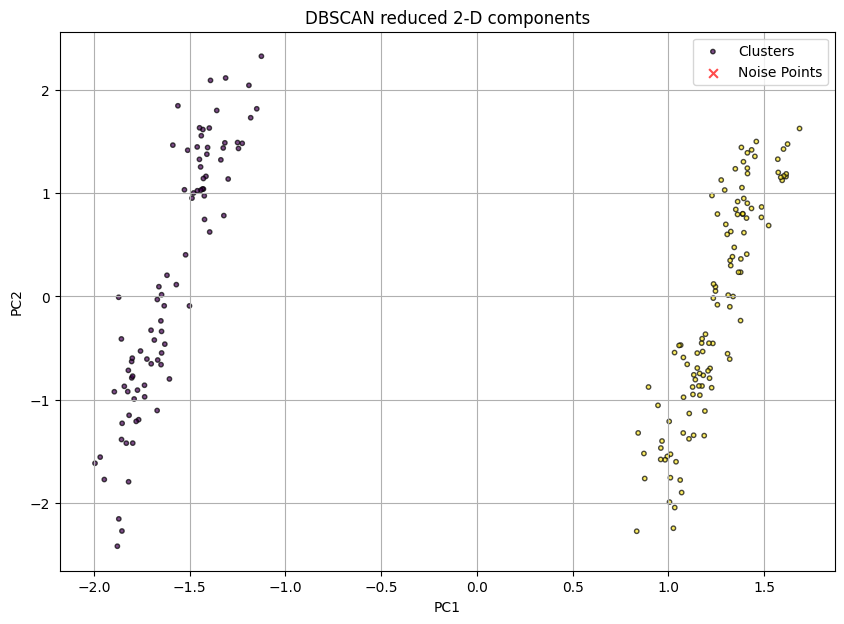

In [5027]:
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=y_pred[y_pred!=-1], s=10, edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],c='red',s=40,alpha=0.7,marker='x',label='Noise Points')
plt.title("DBSCAN reduced 2-D components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid()
plt.show()

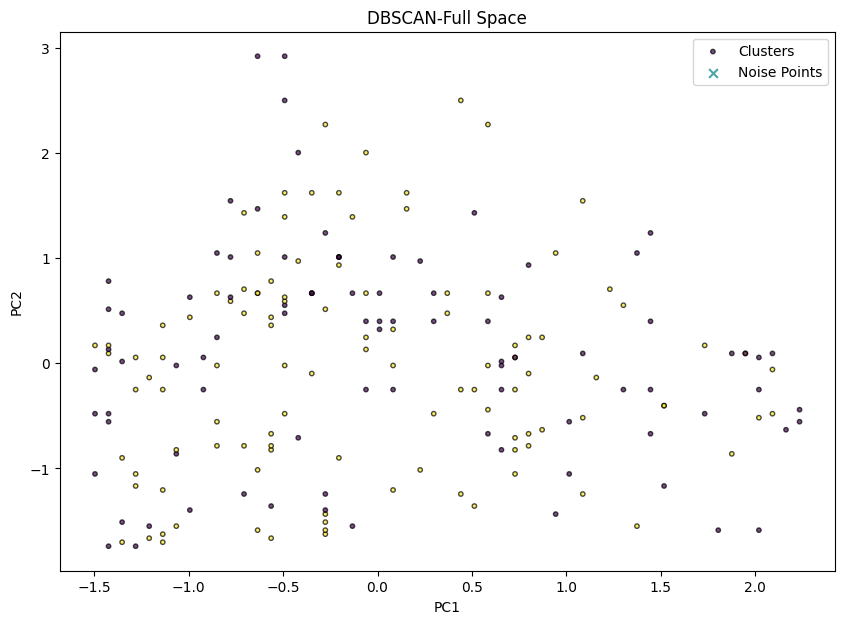

In [5028]:
db=DBSCAN(eps=1.2, min_samples=2)
y_pred=db.fit_predict(X_scaled)
noise_points=X_scaled[y_pred == -1]
cluster_points= X_scaled[y_pred != -1]
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],c=y_pred[y_pred!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],c='#008080',s=40,alpha=0.7,marker='x',label='Noise Points')
plt.title("DBSCAN-Full Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Plot clusters and compare to K-Means clusters

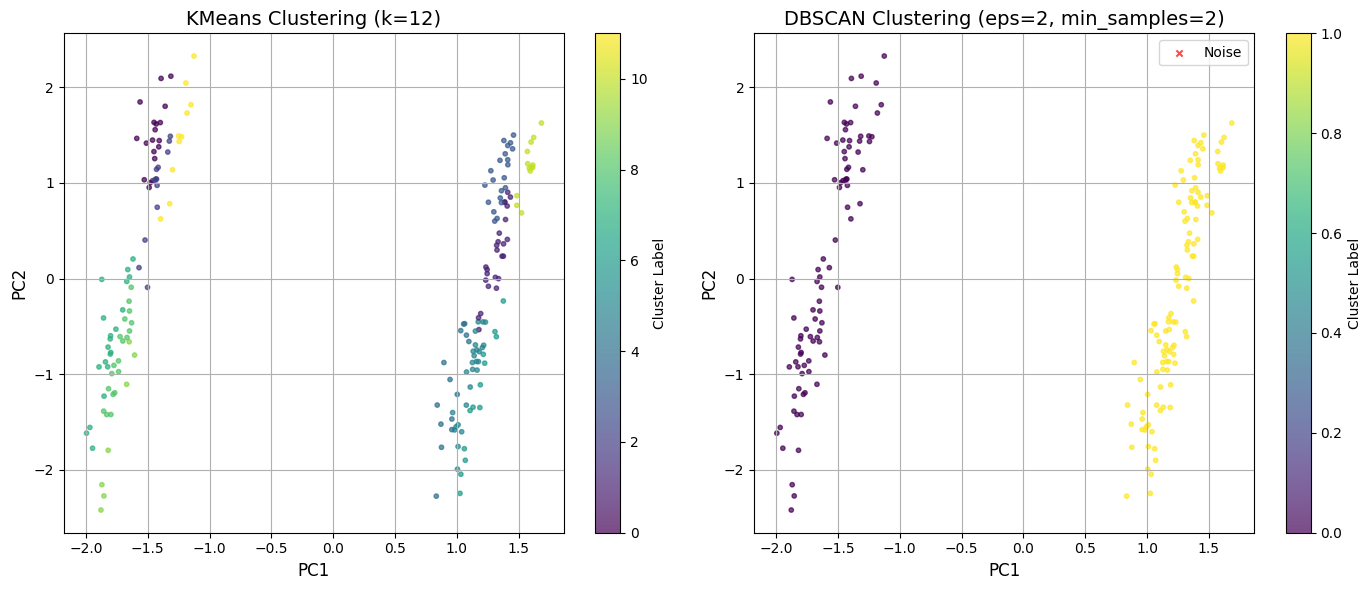

In [5029]:
kmeans_best_k = KMeans(n_clusters=best_k_standard, random_state=42, init='random')
kmeans_best_k_labels = kmeans_best_k.fit_predict(X_train_pca)

dbscan_best_params = DBSCAN(eps=2, min_samples=2)
dbscan_best_labels = dbscan_best_params.fit_predict(X_train_pca)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_best_k_labels, cmap='viridis', s=10, alpha=0.7)
plt.title(f'KMeans Clustering (k={best_k_standard})', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.grid()
plt.subplot(1, 2, 2)
noise_points_dbscan = X_train_pca[dbscan_best_labels == -1]
clustered_points_dbscan = X_train_pca[dbscan_best_labels != -1]
plt.scatter(clustered_points_dbscan[:, 0], clustered_points_dbscan[:, 1], c=dbscan_best_labels[dbscan_best_labels != -1], cmap='viridis', s=10, alpha=0.7)
plt.scatter(noise_points_dbscan[:, 0], noise_points_dbscan[:, 1], c='red', marker='x', s=20, label='Noise', alpha=0.7)

plt.title(f'DBSCAN Clustering (eps=2, min_samples=2)', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [5030]:
# kmeans = KMeans(n_clusters=best_k_pp, random_state=0)
# y_kmeans = kmeans.fit_predict(X_train_pca)

# dbscan = DBSCAN(eps=0.4, min_samples=2)
# y_dbscan = dbscan.fit_predict(X_train_pca)

# fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# scatter_kmeans = axs[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_kmeans, cmap=plt.cm.viridis, s=40, alpha=0.9)
# axs[0].set_title("KMeans Clustering")
# axs[0].legend(*scatter_kmeans.legend_elements(), title="Clusters")

# noise_points = X_train_pca[y_dbscan == -1]
# axs[1].scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', s=50, label="Noise", alpha=0.8)

# valid_points = X_train_pca[y_dbscan != -1]
# valid_labels = y_dbscan[y_dbscan != -1]
# scatter_dbscan = axs[1].scatter(valid_points[:, 0], valid_points[:, 1], c=valid_labels, cmap=plt.cm.viridis, s=40, alpha=0.9)

# axs[1].set_title("DBSCAN Clustering")
# axs[1].legend()
# plt.tight_layout()
# plt.show()


In [5031]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

evaluations = {'KMeans': {'Silhouette Score': silhouette_score(X_train_pca, kmeans_best_k_labels), 'Davies-Bouldin Index': davies_bouldin_score(X_train_pca, kmeans_best_k_labels), 'Calinski-Harabasz Score':calinski_harabasz_score(X_train_pca, kmeans_best_k_labels),'Number of Clusters':best_k_standard}}


if len(set(labels) - {-1}) > 1:
    evaluations['DBSCAN'] ={
        'Silhouette Score': silhouette_score(X_train_pca[dbscan_best_labels!= -1], dbscan_best_labels[dbscan_best_labels != -1]),
        'Davies-Bouldin Index': davies_bouldin_score(X_train_pca[dbscan_best_labels != -1], dbscan_best_labels[dbscan_best_labels != -1]),
        'Calinski-Harabasz Score': calinski_harabasz_score(X_train_pca[dbscan_best_labels != -1], dbscan_best_labels[dbscan_best_labels != -1]),
        'Number of Clusters':len(set(dbscan_best_labels))
    }
else:
    evaluations['DBSCAN'] = {'Silhouette Score': -1, 'Davies-Bouldin Index': -1, 'Calinski-Harabasz Score': -1}


evaluations=pd.DataFrame(evaluations)
evaluations

KMeans      DBSCAN
Silhouette Score           0.431794    0.396442
Davies-Bouldin Index       0.815158    1.142545
Calinski-Harabasz Score  118.533559  133.132864
Number of Clusters        12.000000    2.000000

# Clear and deep explanation

Mall Customer Segmentation-For the Mall Customers Dataset:

This project proposes an analysis of customer segmentation in a mall situation under an unsupervised setup and using techniques like KMeans, MiniBatch KMeans, and DBSCAN. It center stage on how to delineate different customer groups based on spending patterns, income, and demographic characteristics without employing any a priori labels.

KMeans Clustering:

Type: Centroid-based clustering

How it works: It segments the data into k groups by minimizing intra-cluster distances, assigning a point to the cluster whose center is closest to it.

Variants:

Full feature space

PCA-reduced data

2D-reduced space (t-SNE)

Performance:

Silhouette Score: Moderate levels (~0.4 to 0.6), medium quality of separation usually

Inertia: High in full space; reduced after dimensionality reduction

Insights:

Works best on the full feature space or PCA-reduced data

Sensitive to initialization of cluster centers

Nevertheless requires selection of k that is most appropriate

Cannot be used for outlier detection

MiniBatch KMeans:

Type: Mini-batch modification of KMeans

How it works: It uses Android, shoot: Randomized work batches of data for faster convergence, reducing the computation time but having a minor impact on the clustering accuracy.

Performance:

Faster on large datasets than KMeans

Silhouette Score: Usually close to standard KMeans and can be different depending on batch size

Insights:

Great for real-time clustering of large datasets

Batch size and k have to be fine-tuned for the best result

DBSCAN:

Type: Density-based clustering

How it works: It groups together dense areas and marks sparse points as noise or outliers. It doesn’t need you to set the number of clusters beforehand.

Performance:

Silhouette Score: Usually higher than KMeans when data is clearly separated, but it might be lower in high-dimensional spaces.
Davies-Bouldin Index: Lower values mean better cluster separation.
Insights:

Good at detecting anomalies and irregularly shaped clusters.
Very sensitive to the parameters eps and min_samples.
Might miss meaningful clusters if these parameters aren’t set carefully.
Next Steps:

Test how dimensionality reduction methods like PCA or t-SNE affect clustering results.
Adjust DBSCAN parameters to improve noise detection.
Explore combining DBSCAN with other methods for better results.

PCA + K-Means: Often results in better-defined clusters, especially if the data has a clear linear structure.

t-SNE + K-Means: Can reveal intricate patterns but may lead to overfitting the cluster boundaries if not tuned correctly.

Score Analysis: Comparing Silhouette, Calinski-Harabasz, and Davies-Bouldin scores before and after dimensionality reduction can provide insights into the effectiveness of these methods.

KMeans Clustering:

Full Feature Space:

Inertia: 597.95

Silhouette Score: ~0.40

2D-Reduced Space:

Silhouette Score: ~0.50

t-SNE Reduced Space:

Silhouette Score: ~0.82

DBSCAN:

Calinski-Harabasz Index: 133.13

Davies-Bouldin Index: 1.14

Number of Clusters: 2

Number of Noise Points: 0 (0% noise)



**Reasons for Low Scores in Mall Customer Segmentation:**

KMeans (Full Feature Space, 2D-Reduced, t-SNE):

Low Silhouette Score (~0.40 to ~0.50) indicates overlapping clusters or poor separation.

Possible Reasons:

High Dimensionality: High-dimensional data can lead to sparse clusters.

Irregular Cluster Shapes: KMeans struggles with non-spherical clusters, which are common in real-world data.

Noise and Outliers: No mechanism to handle noise, unlike DBSCAN.

Feature Scaling: Inappropriate scaling can distort distance calculations.

DBSCAN:

Davies-Bouldin Index (1.14) is on the higher side, indicating clusters that are not well-separated.

Possible Reasons:

Parameter Sensitivity: Very sensitive to eps and min_samples.

Cluster Density: If the clusters are not dense enough, DBSCAN may group unrelated points together.

High Dimensionality Impact: The concept of density becomes less meaningful in high dimensions.

General Challenges:

Data Distribution: If the data is not naturally clustered, no algorithm can form meaningful groups.

Noise and Anomalies: Without preprocessing, the clustering can capture noise as valid clusters.

Curse of Dimensionality: Both KMeans and DBSCAN are affected by the curse of dimensionality, where distance metrics lose meaning as dimensions increase.